# Synthetic paleomagnetic APWPs inverted using `bayesian_pep` approach

The code is a PyMC3 implementation of the paleomagnetic Euler pole inversion method first developed in PyMC2 within Ian Rose's mcplates package: https://github.com/ian-r-rose/mcplates

The functions are within the `bayesian_pep` library which is imported below.

In [1]:
from bayesian_pep import *
# theano.config.floatX = 'float64'
import seaborn as sns

d2r = np.pi/180
r2d = 180/np.pi
eps = 1.e-6
%config InlineBackend.figure_format = 'retina'

## One Euler pole inversion with minimal age uncertainty

### generate synthetic poles

In [2]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

pole_lon   pole_lat  pole_age  pole_a95
0   24.000000  19.000000     100.0       4.0
1   13.724333  27.231977      75.0       4.0
2  359.854182  30.256654      50.0       4.0
3  346.026499  27.112309      25.0       4.0
4  335.843743  18.796033       0.0       4.0

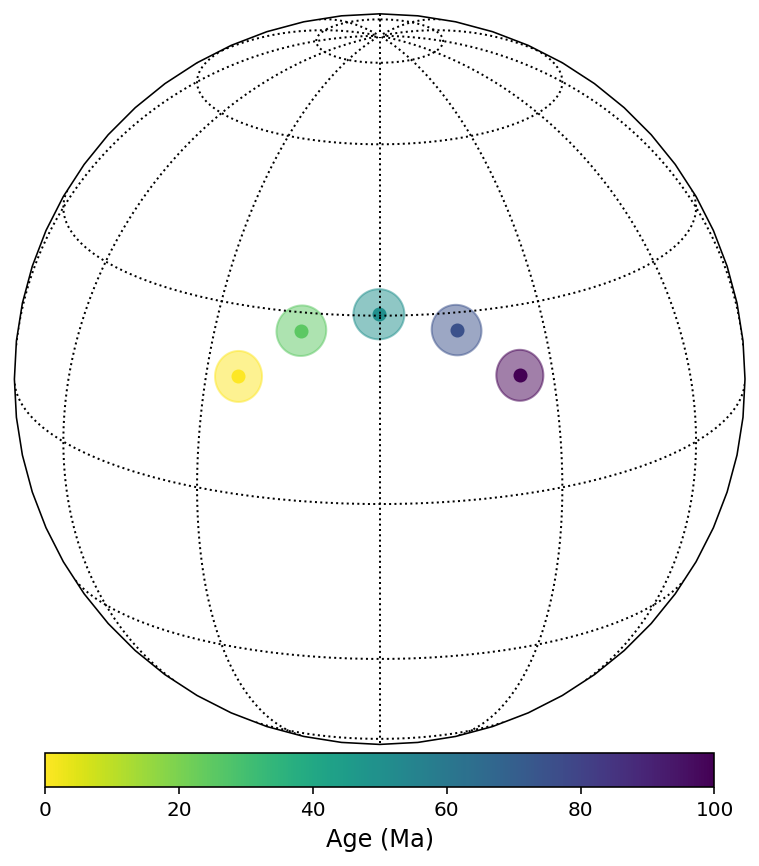

In [3]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates

In [4]:
with pm.Model() as model:
    
    #set the Euler pole position prior to be a uniform distribution (i.e. a Watson girdle with a very low k)
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -0.1, testval = np.array([1., 1.]), shape = 2)
    #set the Euler pole rate prior to be a uniform distribution between 0 and 4
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    #create the Fisher distributions associated with the observed pole positions 
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
    #uncomment to run the model
    #trace_1e = pm.sample(100000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


In [5]:
pm.save_trace(trace_1e, 'code_output/1_euler_trace', overwrite=1)

NameError: name 'trace_1e' is not defined

In [6]:
trace_1e_saved = pm.load_trace('code_output/1_euler_trace',model)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


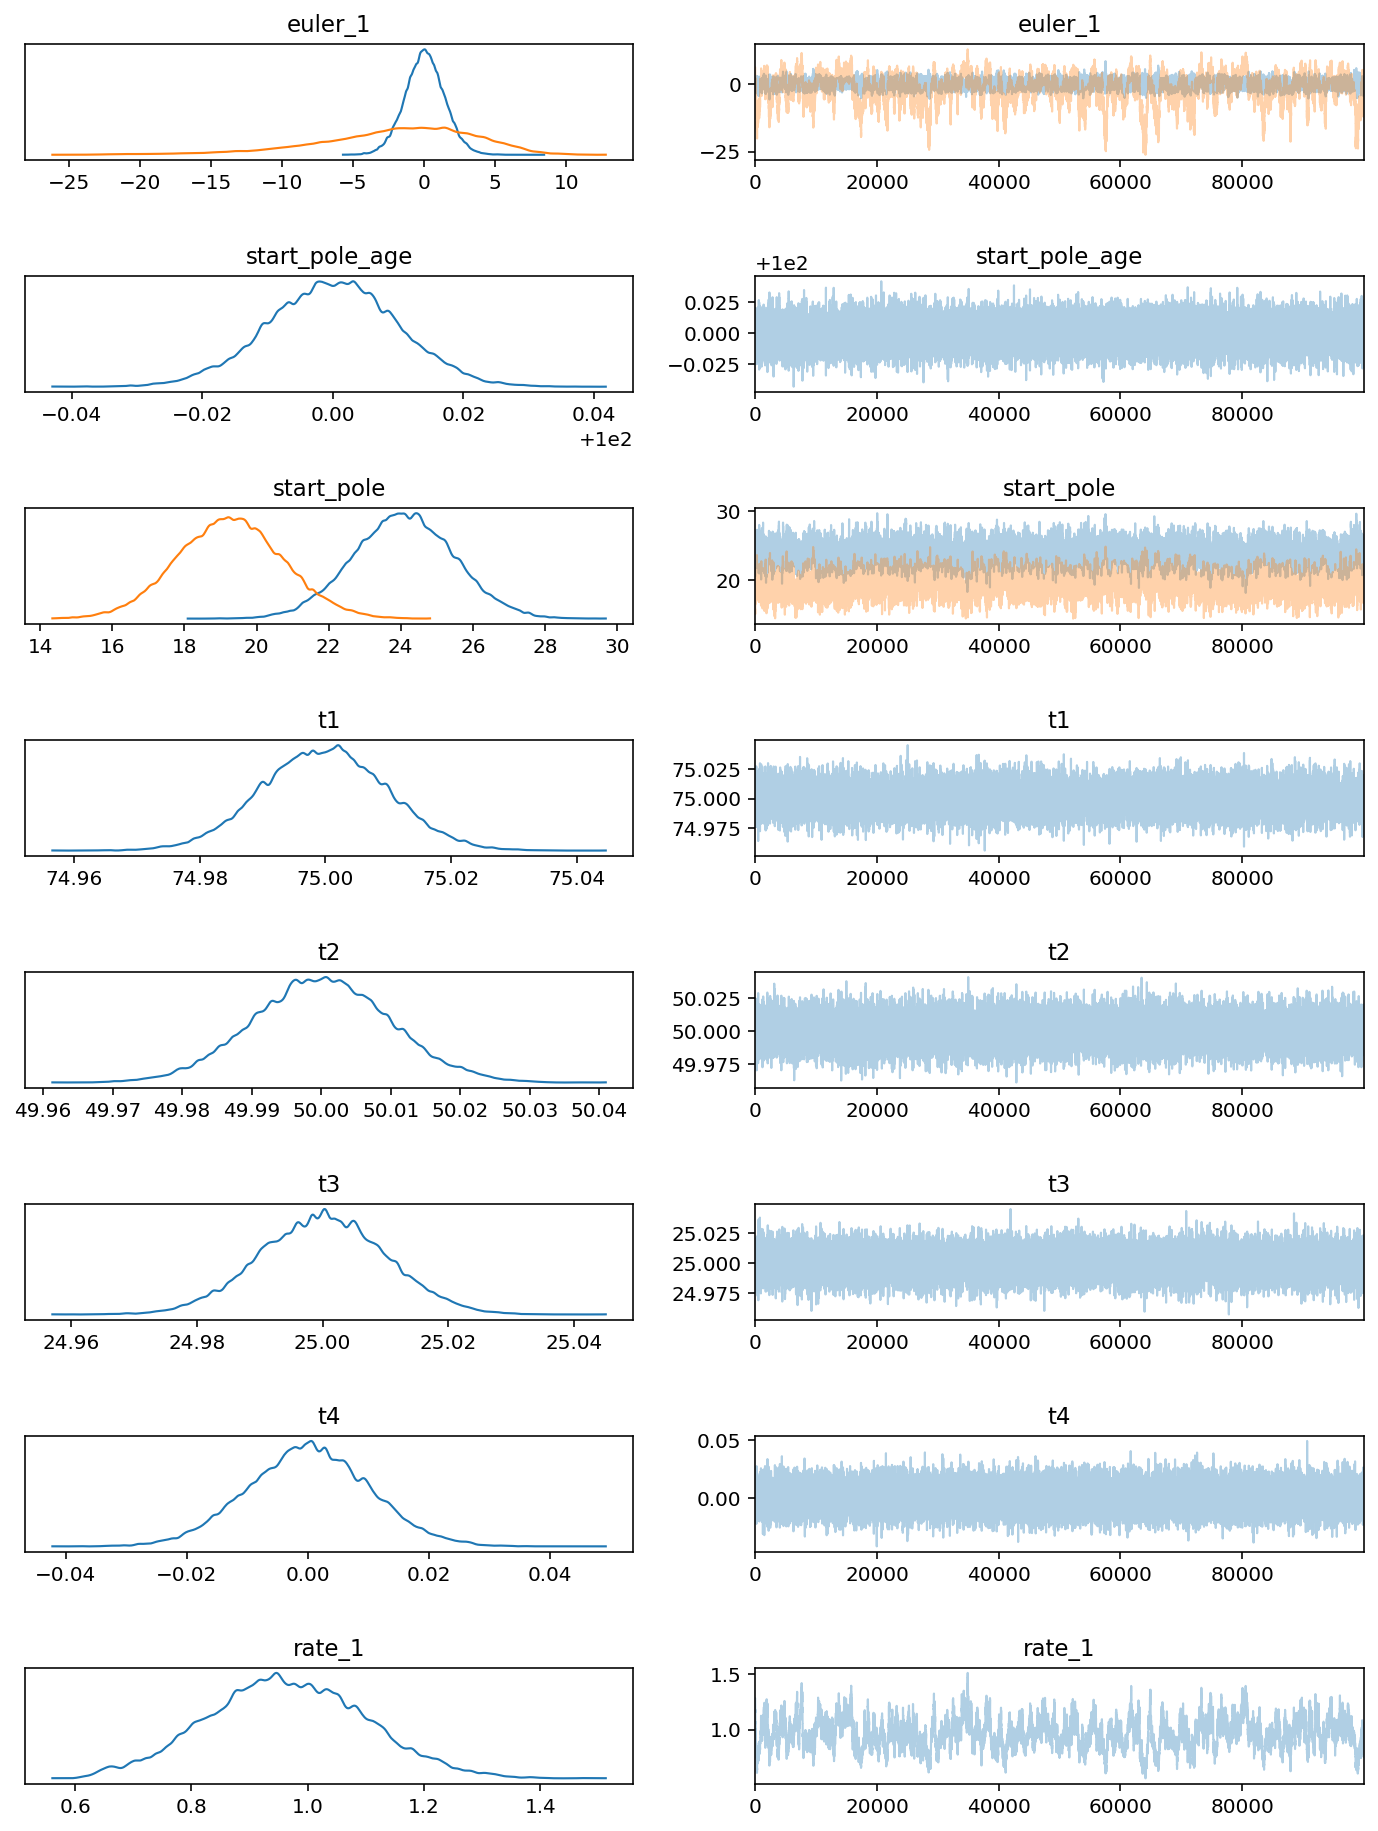

In [7]:
axes = pm.traceplot(trace_1e_saved, compact=1)
plt.subplots_adjust(hspace = 1)
# plt.savefig('code_output/1_euler_inversion_traceplot.pdf', bbox_inches='tight')

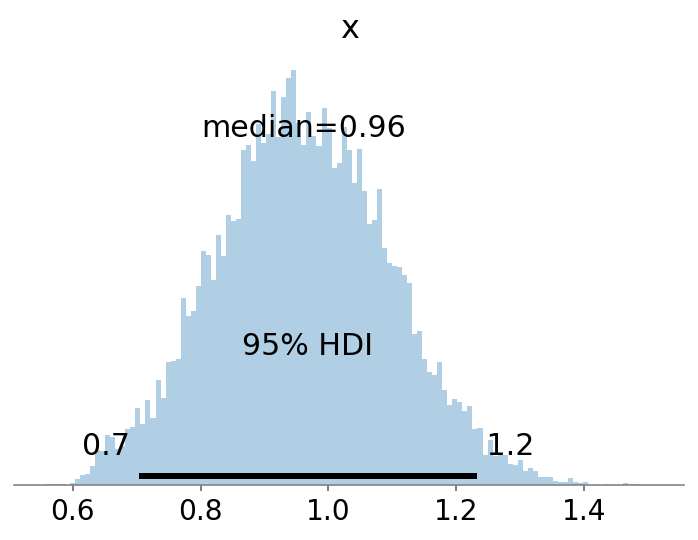

In [7]:
az.plot_posterior(trace_1e_saved['rate_1'],kind='hist',point_estimate='median',hdi_prob=0.95)
plt.show()

0.9611758891239083 0.7036047937759307 1.2325747400942728


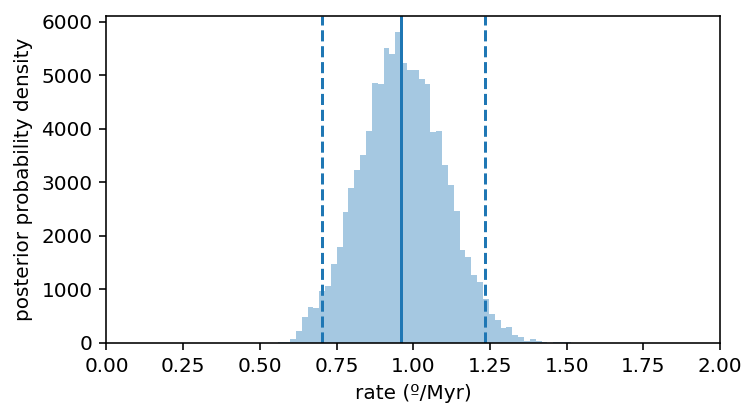

In [98]:
HPD_max = np.percentile(trace_1e_saved['rate_1'],97.5)
HPD_min = np.percentile(trace_1e_saved['rate_1'],2.5)
median = np.median(trace_1e_saved['rate_1'])
print(median, HPD_min, HPD_max)

plt.figure(figsize=(5.5,3))
sns.distplot(trace_1e_saved['rate_1'],kde=False)
plt.axvline(x=median)
plt.axvline(x=HPD_min,linestyle='--')
plt.axvline(x=HPD_max,linestyle='--')
plt.xlabel('rate (º/Myr)')
plt.ylabel('posterior probability density')
plt.xlim(0,2)
plt.savefig('code_output/1_Euler_inversion_rate.png',dpi=600,bbox_inches='tight')

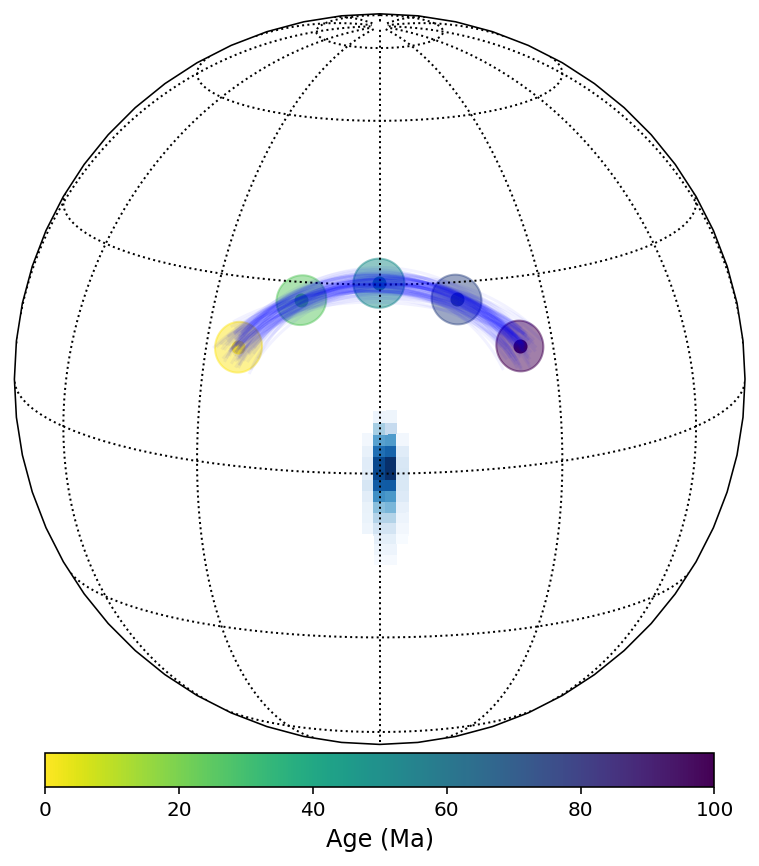

In [14]:
plot_trace_1e(trace_1e_saved, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=15, num_points_to_plot=100, num_paths_to_plot=100, cmap='Blues',
              savefig = True, figname = 'code_output/1_Euler_inversion.png');

## Two Euler pole inversion

### generate synthetic poles

In [8]:
start_age = 120
end_age = 60
number_of_poles = 4
euler_pole = [30,30]
euler_rate = -1.2
pole_a95 = 4
start_pole = [30, 0]

two_euler_data_1 = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)

start_age = 60
end_age = 0
number_of_poles = 4
euler_pole = [-20,30]
euler_rate = 0.8
pole_a95 = 4
start_pole = [two_euler_data_1['pole_lon'][3], two_euler_data_1['pole_lat'][3]]

two_euler_data_2 = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
two_euler_data = pd.concat([two_euler_data_1,two_euler_data_2[1:]])
two_euler_data.reset_index(inplace=True)

In [9]:
two_euler_data

index   pole_lon   pole_lat  pole_age  pole_a95
0      0  30.000000   0.000000     120.0       4.0
1      1  18.257653   2.145421     100.0       4.0
2      2   7.948139   8.237149      80.0       4.0
3      3   0.108539  17.409825      60.0       4.0
4      1   3.446208  22.572361      40.0       4.0
5      2   5.454325  28.334060      20.0       4.0
6      3   5.847554  34.364616       0.0       4.0

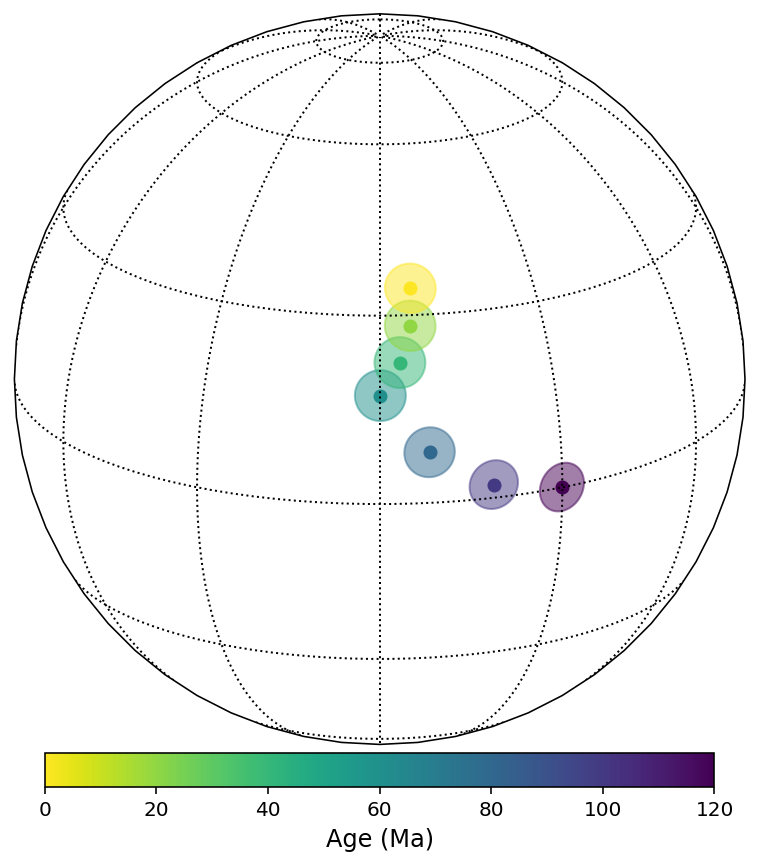

In [10]:
plot_paleomagnetic_poles(two_euler_data, central_latitude=20, add_land=0);

In [11]:
with pm.Model() as model:

    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,0.,], k = -1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0, 4)  
    euler_2 = Watson_Girdle('euler_2', lon_lat = [1.,0.,], k = -1., testval = np.array([1., 0.]), shape = 2)
    rate_2 = pm.Uniform('rate_2', 0, 4) 
    
    start_age = pm.Normal('start_pole_age', two_euler_data['pole_age'].max(), 0.01)
    print('starting pole age is: ', str(two_euler_data['pole_age'].max()))
    
    start_index = two_euler_data['pole_age'].argmax()
    
    start_lon_lat = [two_euler_data['pole_lon'].tolist()[start_index], two_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(two_euler_data['pole_a95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    
    switchpoint = pm.Uniform('switchpoint', two_euler_data['pole_age'].min(), two_euler_data['pole_age'].max())


    for i in range(two_euler_data.shape[0]):
        
        age = pm.Normal('t'+str(i), mu=two_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',two_euler_data['pole_age'][i])
        
        lon_lat = pole_position_2e(start, euler_1, rate_1, euler_2, rate_2, switchpoint, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(two_euler_data['pole_a95'].tolist()[i]), 
                            observed=[two_euler_data['pole_lon'].tolist()[i], two_euler_data['pole_lat'].tolist()[i]])
        
    trace_2e = pm.sample(10000, step = pm.Metropolis(), compute_convergence_checks=1, cores=1)

starting pole age is:  120.0
pole 0 age:  120.0
pole 1 age:  100.0
pole 2 age:  80.0
pole 3 age:  60.0
pole 4 age:  40.0
pole 5 age:  20.0
pole 6 age:  0.0


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [t6]
>Metropolis: [t5]
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [switchpoint]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_2]
>Metropolis: [euler_2]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 2025 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


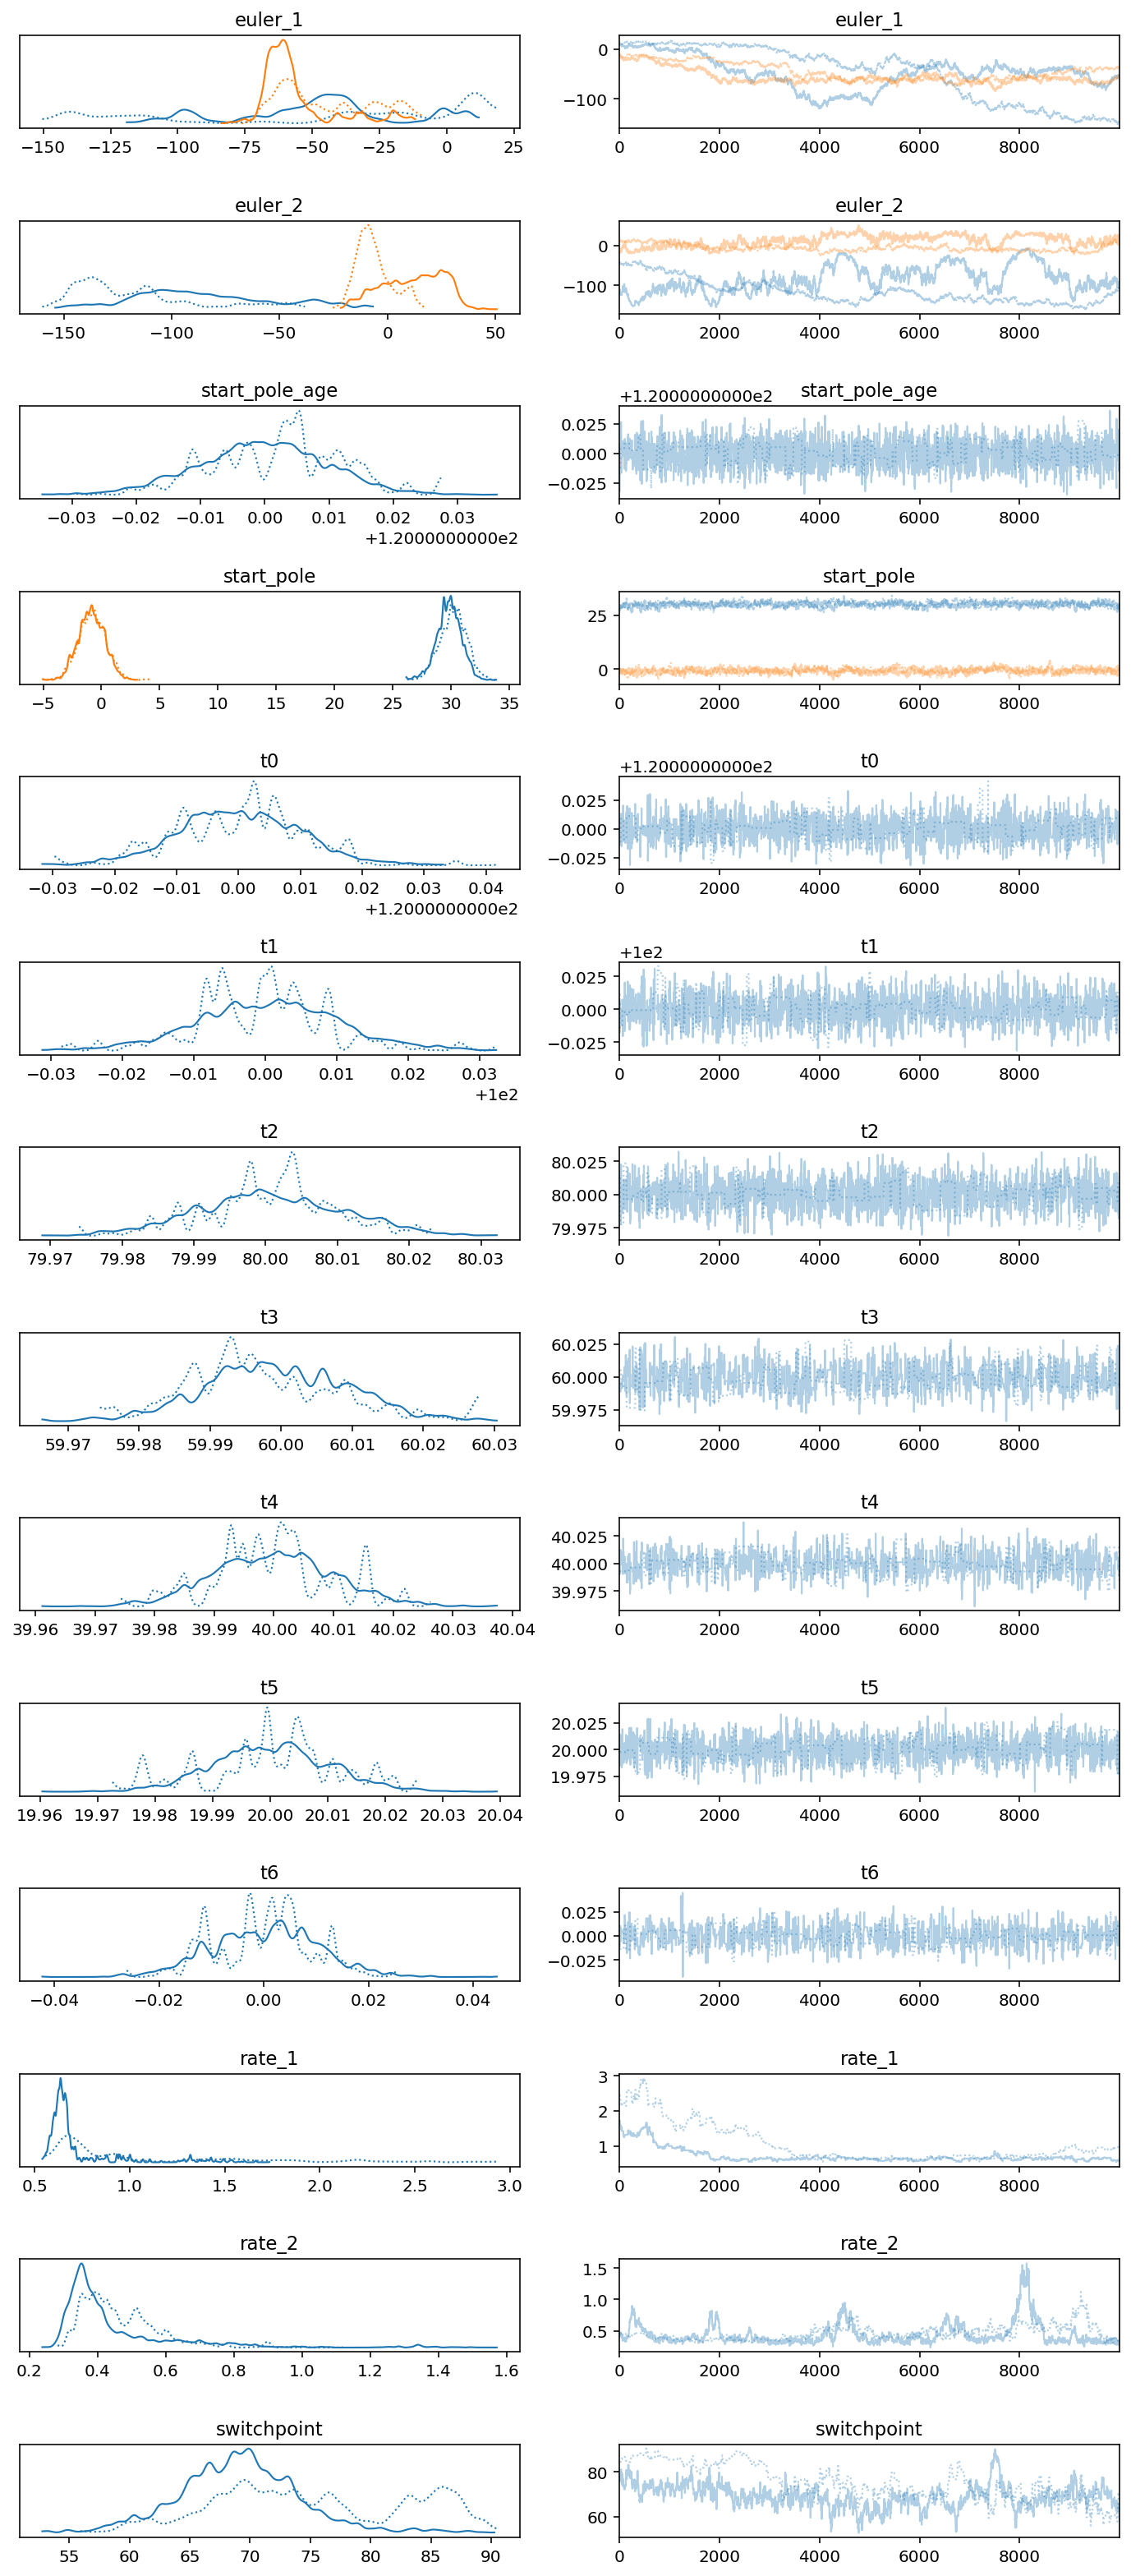

In [12]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_2e, compact=1)
plt.subplots_adjust(hspace = 1 )
plt.savefig('code_output/2_euler_inversion_traceplot.pdf', bbox_inches='tight')

In [13]:
pm.save_trace(trace_2e, 'code_output/2_euler_trace', overwrite=1)

'code_output/2_euler_trace'

In [14]:
trace_2e_saved = pm.load_trace('code_output/2_euler_trace',model)

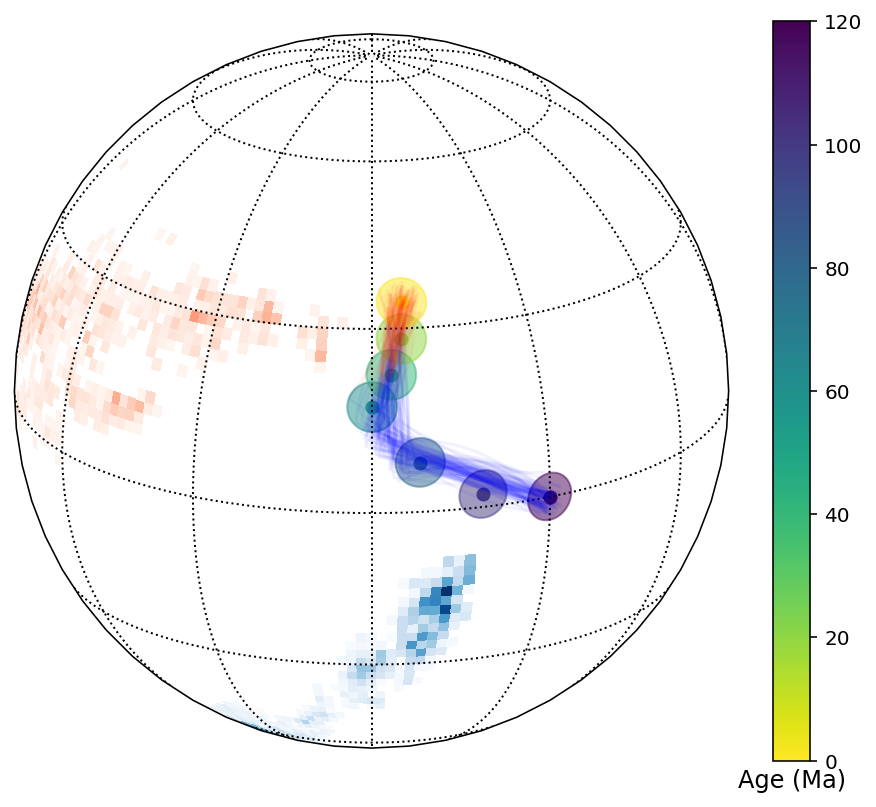

In [16]:
plot_trace_2e(trace_2e_saved, two_euler_data[['pole_lon', 'pole_lat']].to_numpy(), two_euler_data['pole_a95'], two_euler_data['pole_age'].tolist(), 0, 20, 100, 100, savefig = 0, figname='2_Euler_inversion_test.pdf')

## Generate figure of synthetic 1 and 2 Euler inversions

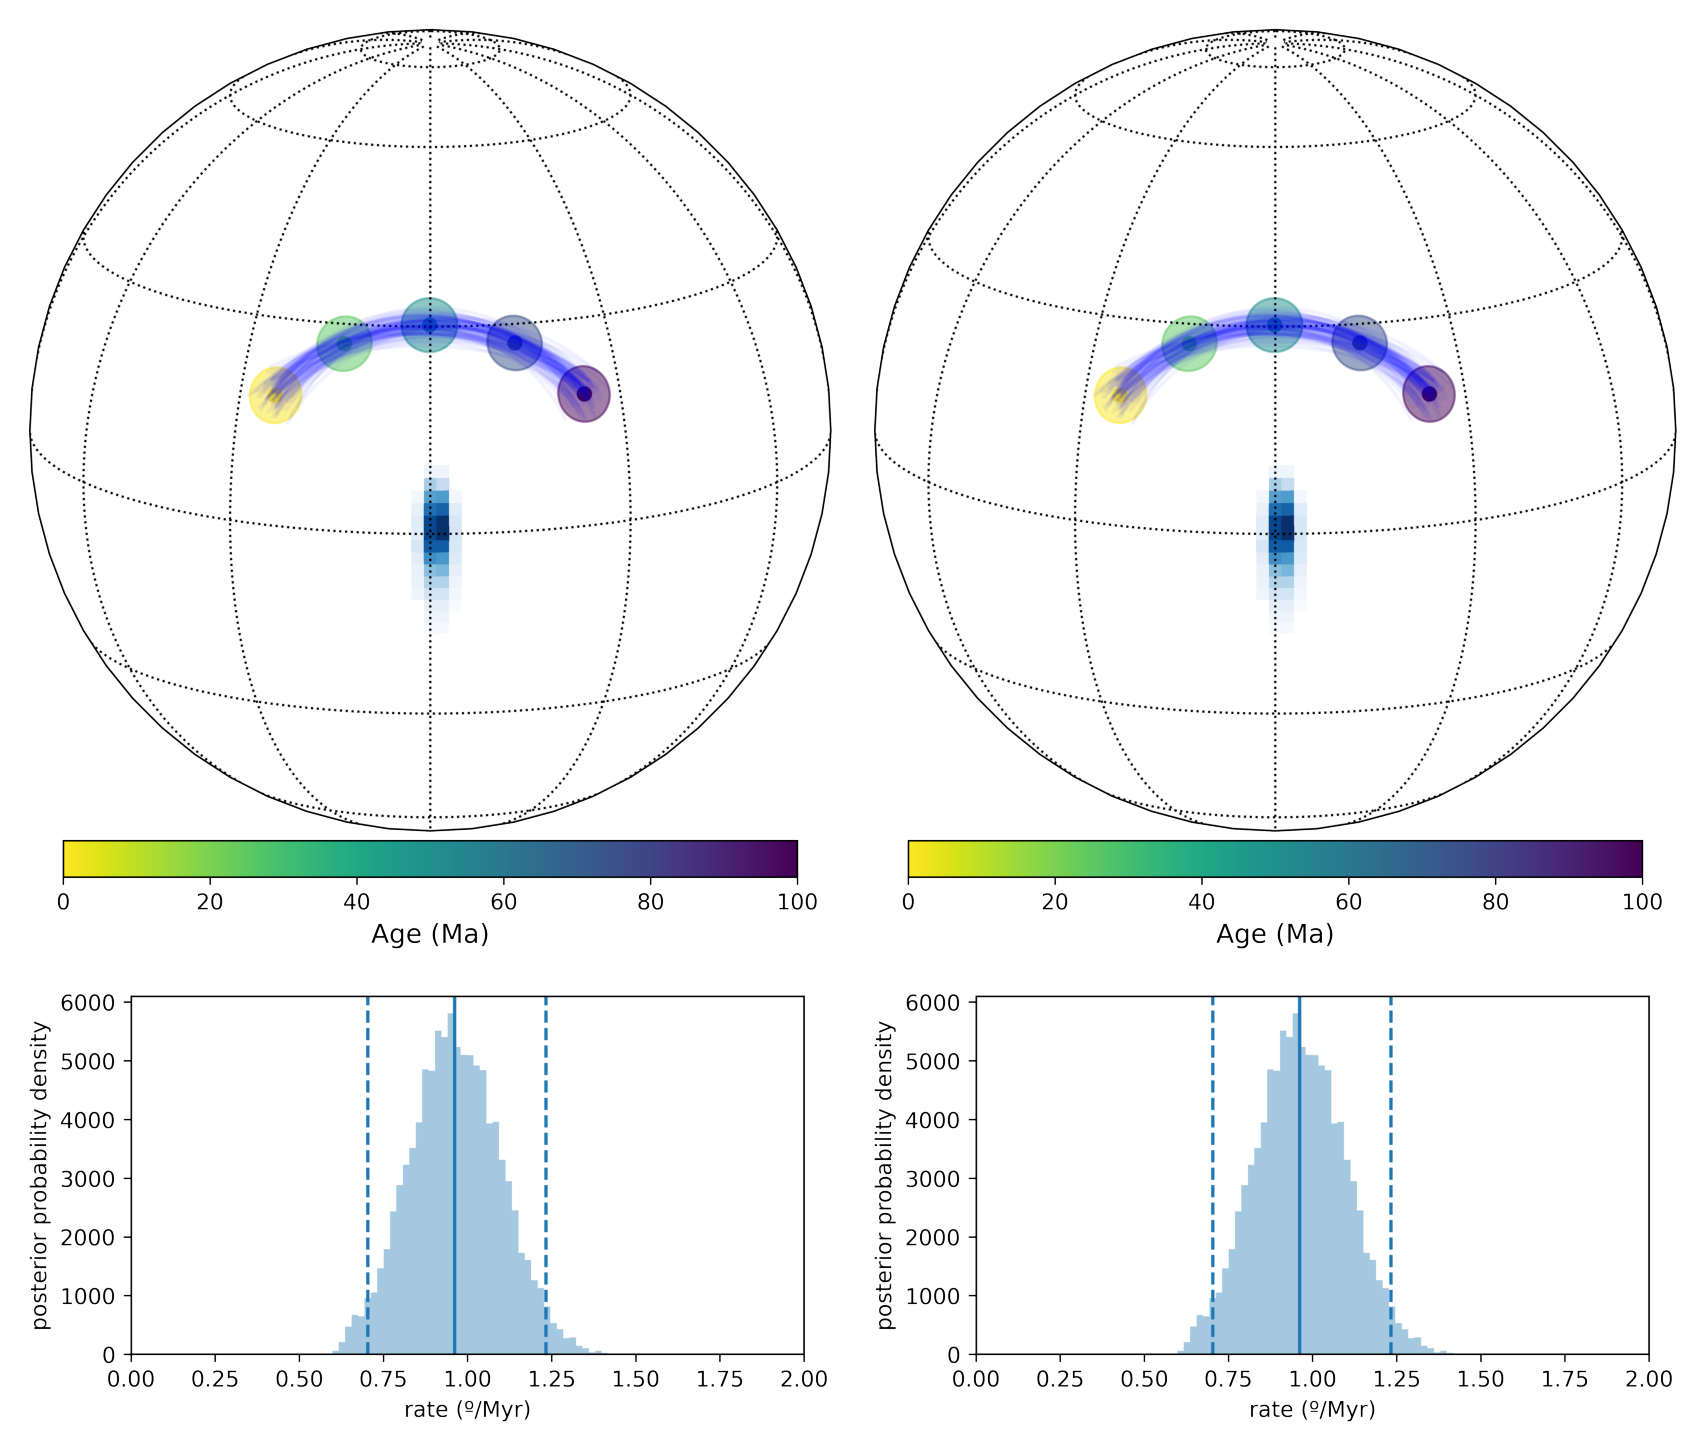

In [97]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.image as mpimg

one_euler_map_img = mpimg.imread('code_output/1_Euler_inversion.png')
one_euler_rate_img = mpimg.imread('code_output/1_Euler_inversion_rate.png')


fig = plt.figure(figsize=(15., 15.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, [one_euler_map_img,
                         one_euler_map_img,
                         one_euler_rate_img,
                         one_euler_rate_img]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
    ax.axis("off")


plt.subplots_adjust(wspace=0.2, hspace=0)

plt.savefig('./code_output/fig_synthetic_pep.png',dpi=600,bbox_inches='tight')
plt.show()

## One Euler pole inversion with various age constraints

### generate synthetic poles

In [109]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_age_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_age_data['pole_age'] = [120., None, None, None, 20.]
one_euler_age_data['age_sigma'] = [10., None, None, None, 10.]
one_euler_age_data

pole_lon   pole_lat  pole_age  pole_a95  age_sigma
0   24.000000  19.000000     120.0       4.0       10.0
1   13.724333  27.231977       NaN       4.0        NaN
2  359.854182  30.256654       NaN       4.0        NaN
3  346.026499  27.112309       NaN       4.0        NaN
4  335.843743  18.796033      20.0       4.0       10.0

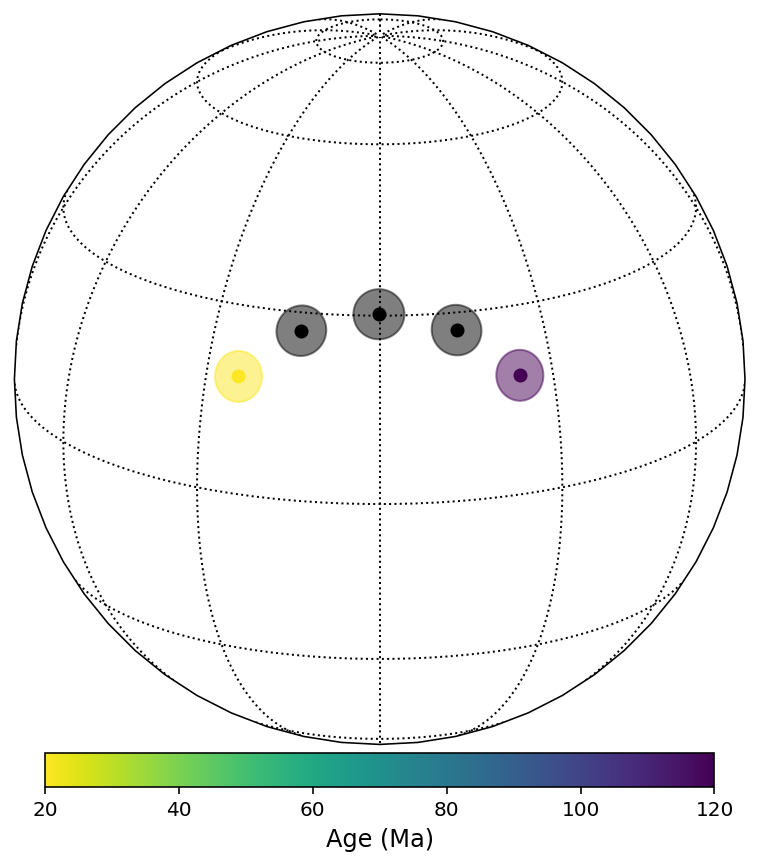

In [110]:
plot_paleomagnetic_poles(one_euler_age_data, central_latitude=20, add_land=0);

### generate pole age prior distributions

In [121]:
def get_age_boundaies(ages, age_sigmas):
    real_ages = []
    real_sigma = []
    for i in range(len(ages)):
        if np.isnan(age_sigmas[i]) == 0  :
            real_ages.append(ages[i])
            real_sigma.append(age_sigmas[i])
#     print(real_ages)      
    age_upper = max(real_ages)+3*age_sigmas[np.argmax(real_ages)]
    age_lower = min(real_sigma)-3*age_sigmas[np.argmin(real_sigma)]
    return max(real_ages), min(real_sigma), age_upper, age_lower

def plot_age_prior(ages, age_sigmas, **kwargs):

    age_max, age_min, age_upper, age_lower = get_age_boundaies(ages, age_sigmas)
    
#     print(age_upper, age_lower)
    fig, ax = plt.subplots(figsize=(15, 6))

    cNorm  = matplotlib.colors.Normalize(vmin=age_min, vmax=age_max)
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

    color_list = [colors.rgb2hex(scalarMap.to_rgba(ages[i])) for i in range(len(ages))]

    cbar = plt.colorbar(scalarMap, shrink=0.85)
    cbar.ax.set_xlabel('Age (Ma)', fontsize=12)                               
    max_y = 0
                                       
    for i in range(len(ages)):
        this_age = ages[i]
        this_age_sigma = age_sigmas[i]


        if np.isnan(this_age_sigma) == 1:
            # this means we do not know the age of the pole except it is between the min and max age of the list

            x = np.linspace(age_lower, age_upper, 500)
            y = np.zeros(500)
            y[(x< age_upper) & (x>age_lower)] = 1.0/(age_upper-age_lower)

            color_list[i] = 'grey'
            if max_y < max(y):
                max_y = max(y)
                                       
        else:
            mu = this_age
            sigma = this_age_sigma

            x = np.linspace(mu-3*sigma,mu+3*sigma, 1000)
            y = st.norm.pdf(x, mu, sigma)
            if max_y < max(y):
                max_y = max(y)
        ax.plot(x, y, color = color_list[i], lw=1)
        ax.fill_between(x, y, color = color_list[i], alpha = 0.2)
        
    ax.grid(ls='--')
    ax.set_xlim(age_lower*0.9, age_upper+age_lower*0.1)
    ax.set_ylim(0, max_y*1.1)
    ax.set_ylabel('Probability density')
    ax.set_xlabel('Age (Ma)')
    ax.set_title('Prior distributions assigned to age of poles', fontdict={'fontsize':14})
    
    return ax

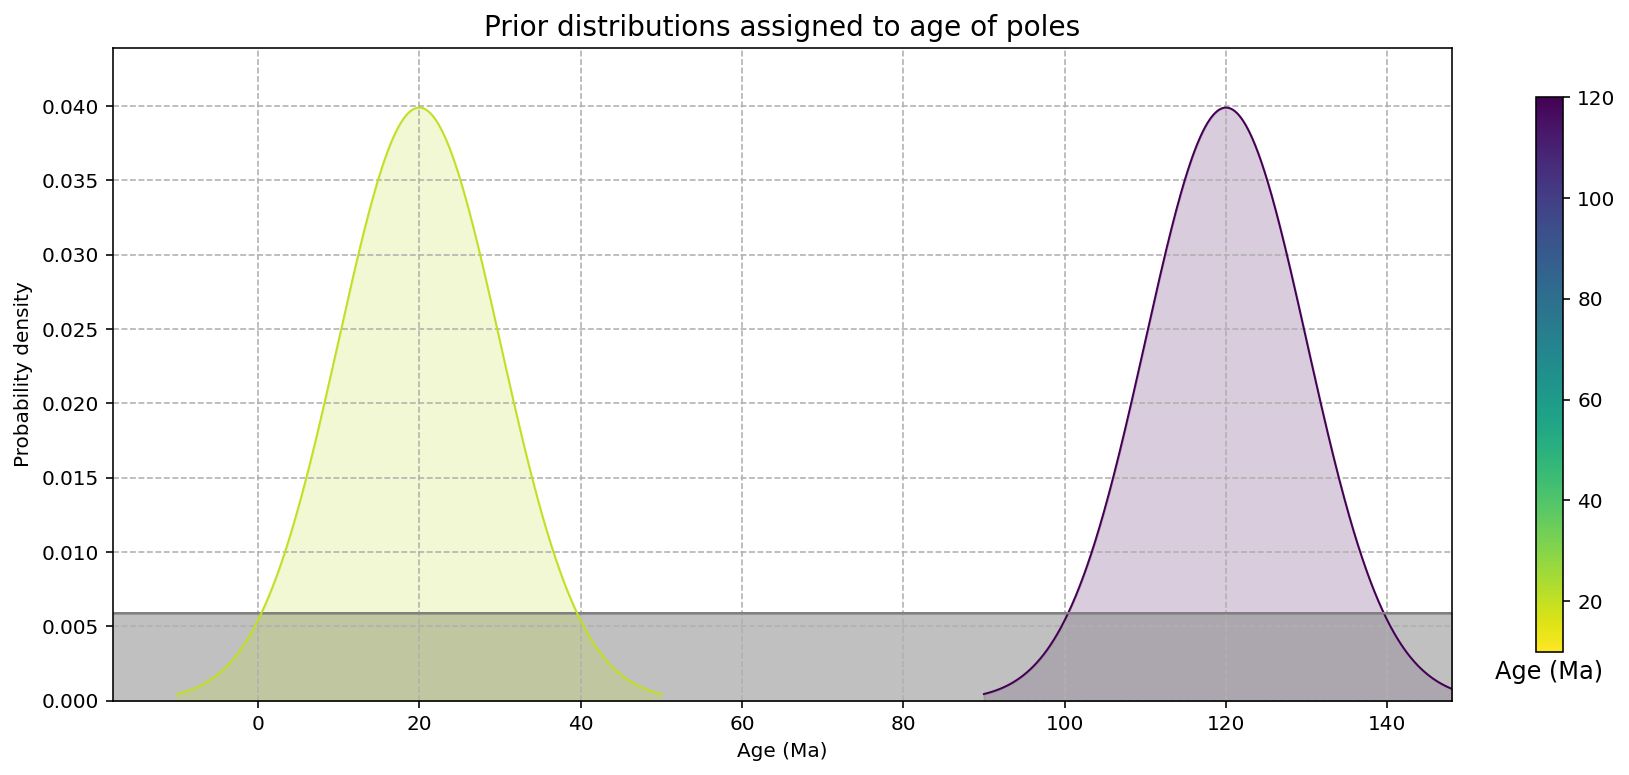

In [122]:
plot_age_prior(one_euler_age_data['pole_age'].tolist(), one_euler_age_data['age_sigma'].tolist())
plt.savefig('code_output/age_prior_distributions.pdf')

### invert for the Euler poles and Euler rates

In [123]:
with pm.Model() as model:
    
    _, _ , age_upper, age_lower = get_age_boundaies(one_euler_age_data['pole_age'].tolist(), one_euler_age_data['age_sigma'].tolist())
    print('upper age bound: ', age_upper, 'lower age bound: ', age_lower)
    
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -1., testval = np.array([1., 1.]), shape = 2)
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    start_age = pm.Normal('start_pole_age', one_euler_age_data['pole_age'].max(), 0.1)
    print('starting pole age is: ', str(one_euler_age_data['pole_age'].max()))
    
    start_index = one_euler_age_data['pole_age'].argmax()
    
    start_lon_lat = [one_euler_age_data['pole_lon'].tolist()[start_index], one_euler_age_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_age_data['pole_a95'].tolist()[start_index])
    
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    
    for i in range(one_euler_age_data.shape[0]):
        if np.isnan(one_euler_age_data['age_sigma'][i]) == 1:
            # uniform
            age = pm.Uniform('t'+str(i), age_lower, age_upper)
            print('pole '+str(i)+' age: ', age_lower, '-', age_upper)
        else: 
            age = pm.Normal('t'+str(i), mu=one_euler_age_data['pole_age'][i], sigma=one_euler_age_data['age_sigma'][i])
            
            print('pole '+str(i)+' age: ',one_euler_age_data['pole_age'][i], '\pm', one_euler_age_data['age_sigma'][i])
        
        lon_lat = pole_position_1e(start, euler_1, rate_1, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_age_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_age_data['pole_lon'].tolist()[i], one_euler_age_data['pole_lat'].tolist()[i]])
        
    trace_1e = pm.sample(10000, step = pm.Metropolis(), compute_convergence_checks=1, cores=1, init='auto')

upper age bound:  150.0 lower age bound:  -20.0
starting pole age is:  120.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 0 age:  120.0 $\pm$ 10.0
pole 1 age:  -20.0 - 150.0
pole 2 age:  -20.0 - 150.0
pole 3 age:  -20.0 - 150.0
pole 4 age:  20.0 $\pm$ 10.0


Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [t0]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 1 chain for 58 tune and 0 draw iterations (58 + 0 draws total) took 2 seconds.
No posterior samples. Unable to run convergence checks


Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 720x720 with 0 Axes>

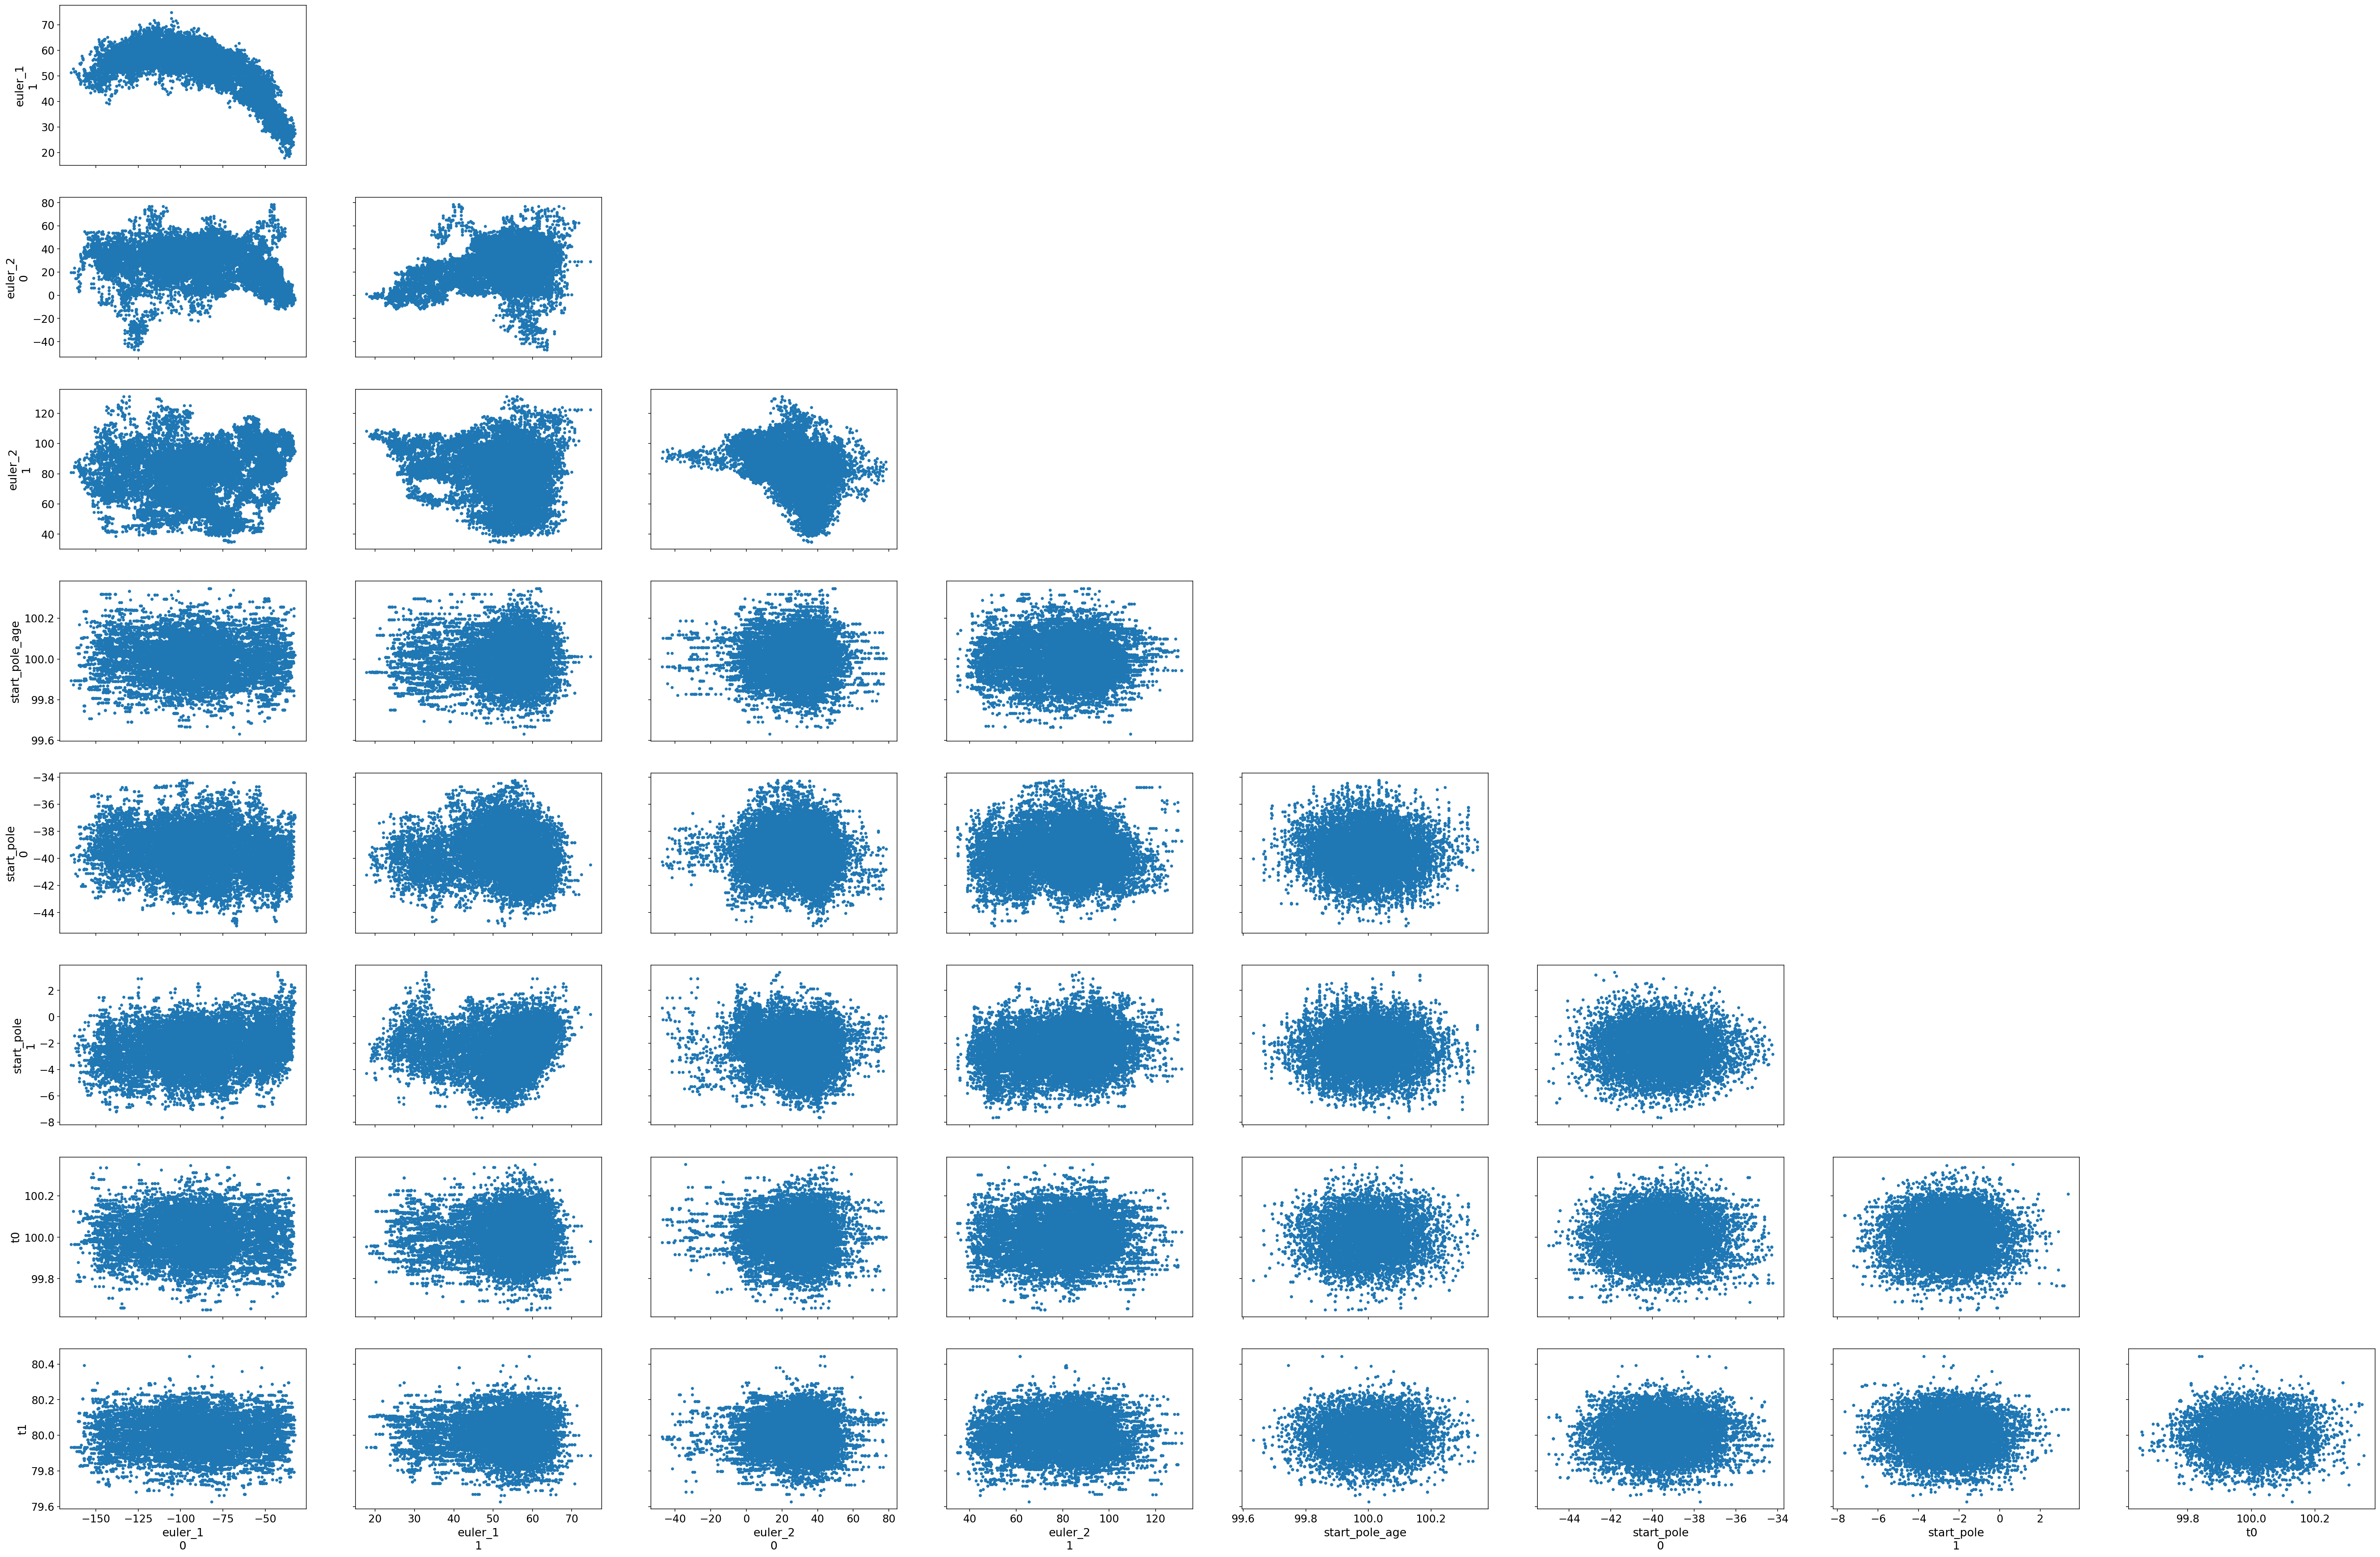

In [16]:
plt.figure(figsize=(10,10))
az.plot_pair(
    trace_2e);
plt.savefig('code_output/2_euler_pairplot.png', bbox_inches='tight', dpi=300);

## One Euler and tpw inversion

### generate synthetic poles

In [18]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

pole_lon   pole_lat  pole_age  pole_a95
0   24.000000  19.000000     100.0       4.0
1   13.724333  27.231977      75.0       4.0
2  359.854182  30.256654      50.0       4.0
3  346.026499  27.112309      25.0       4.0
4  335.843743  18.796033       0.0       4.0

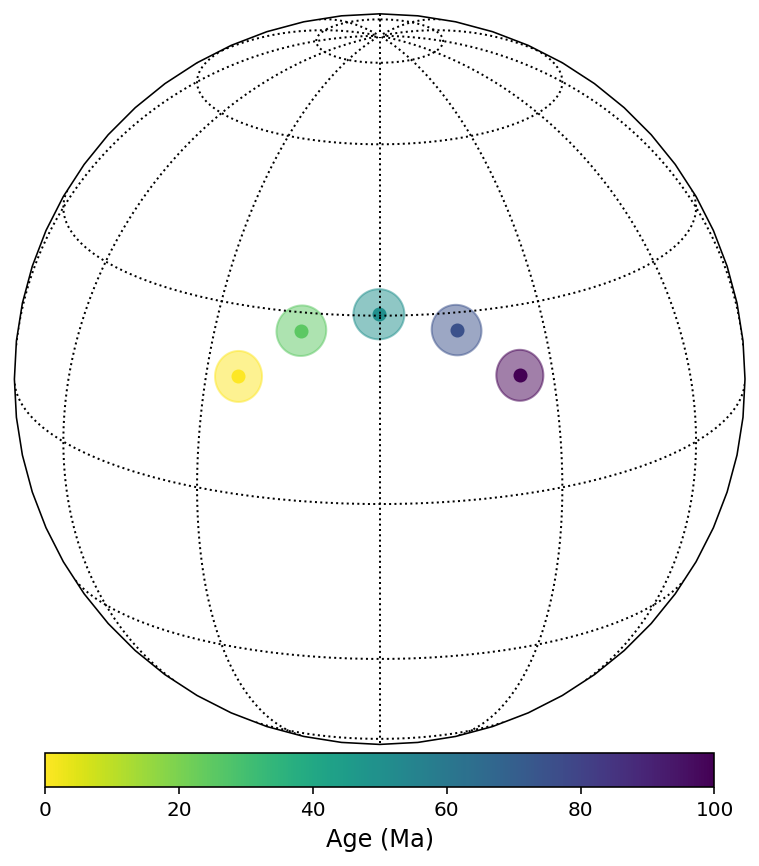

In [19]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

### invert for the Euler poles and Euler rates, tpw and tpw rates

In [79]:
@as_op(itypes=[T.dvector, T.dvector, T.dscalar, T.dscalar, T.dscalar, T.dscalar, T.dscalar], otypes=[T.dvector])
def pole_position_1e_tpw(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age):
    
    start_pole = PaleomagneticPole(start[0], start[1], age=start_age)
    
    euler_pole_1 = EulerPole(euler_1[0], euler_1[1], rate_1)
    
    # make a TPW pole
    test_1 = np.array([0.,0.,1.])
    test_2 = np.array([1.,0.,0.])
    if np.dot(start_pole._pole, test_1) > np.dot(start_pole._pole, test_2):
        great_circle_pole = np.cross(start_pole._pole, test_2)
    else:
        great_circle_pole = np.cross(start_pole._pole, test_1)
    lon, lat, _ = cartesian_to_spherical(great_circle_pole)

    TPW = EulerPole(lon[0], lat[0], tpw_rate)
    TPW.rotate(start_pole, tpw_angle)
    
    this_euler = euler_pole_1.copy()
    this_euler.rotate(TPW, TPW.rate*(start_age-age))
    start_pole.rotate(TPW, TPW.rate*(start_age-age))
    
    start_pole.rotate(this_euler, this_euler.rate*(start_age-age))

    lon_lat = np.ndarray.flatten(np.array([start_pole.longitude, start_pole.latitude]))

    return lon_lat


def plot_trace_1e_tpw(trace, lon_lats, A95s, ages, central_lon = 30., central_lat = 30., num_paths_to_plot = 200, 
                  savefig = False, figname = 'code_output/1_Euler_inversion_.pdf', **kwargs):
    def pole_position(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age):

        start_pole = PaleomagneticPole(start[0], start[1], age=start_age)

        euler_pole_1 = EulerPole(euler_1[0], euler_1[1], rate_1)

        # make a TPW pole
        test_1 = np.array([0.,0.,1.])
        test_2 = np.array([1.,0.,0.])
        if np.dot(start_pole._pole, test_1) > np.dot(start_pole._pole, test_2):
            great_circle_pole = np.cross(start_pole._pole, test_2)
        else:
            great_circle_pole = np.cross(start_pole._pole, test_1)
        lon, lat, _ = cartesian_to_spherical(great_circle_pole)

        TPW = EulerPole(lon[0], lat[0], tpw_rate)
        TPW.rotate(start_pole, tpw_angle)

        this_euler = euler_pole_1.copy()
        this_euler.rotate(TPW, TPW.rate*(start_age-age))
        start_pole.rotate(TPW, TPW.rate*(start_age-age))

        start_pole.rotate(this_euler, this_euler.rate*(start_age-age))

        lon_lat = np.ndarray.flatten(np.array([start_pole.longitude, start_pole.latitude]))

        return lon_lat
    
    euler_1_directions = trace.euler_1
    euler_rates_1 = trace.rate_1
    
    tpw_angle = trace.tpw_angle
    tpw_rate = trace.tpw_rate
    
    start_age = trace.start_pole_age
    start_directions = trace.start_pole

    interval = max([1,int(len(euler_rates_1)/num_paths_to_plot)])

    ax = ipmag.make_orthographic_map(central_lon, central_lat, add_land=0, grid_lines = 1)
    
    plot_distributions(ax, euler_1_directions[:,0], euler_1_directions[:,1], cmap='Blues')
            
    age_list = np.linspace(ages[0], ages[-1], num_paths_to_plot)
    pathlons = np.empty_like(age_list)
    pathlats = np.empty_like(age_list)
    
    tpw_directions = np.empty_like(trace.start_pole[:])
    index=0
    for start, tpw_a in zip(start_directions, tpw_angle):
        test_1 = np.array([0.,0.,1.])
        test_2 = np.array([1.,0.,0.])
        start_pole = Pole(start[0], start[1], 1.0)
        if np.dot(start_pole._pole, test_1) > np.dot(start_pole._pole, test_2):
            great_circle_pole = np.cross(start_pole._pole, test_2)
        else:
            great_circle_pole = np.cross(start_pole._pole, test_1)
        lon, lat, _ = cartesian_to_spherical(great_circle_pole)
        TPW = Pole(lon[0], lat[0], 1.0)
        TPW.rotate(start_pole, tpw_a)
        tpw_directions[index, :] = np.ndarray.flatten(np.array([TPW.longitude, TPW.latitude]))
        index += 1

    plot_distributions(ax, tpw_directions[:,0], tpw_directions[:,1], cmap='Reds')
    
    for start, e1, r1, tpw_a, tpw_r, start_a in zip(start_directions[::interval], 
                        euler_1_directions[::interval], euler_rates_1[::interval], 
                        tpw_angle[::interval], tpw_rate[::interval], start_age[::interval]):
            
        for i,a in enumerate(age_list):
            lon_lat = pole_position( start, e1, r1, tpw_a, tpw_r, start_a, a)
            pathlons[i] = lon_lat[0]
            pathlats[i] = lon_lat[1]

        ax.plot(pathlons,pathlats,color='b', transform=ccrs.PlateCarree(), alpha=0.05)
        
        
    # plot paleomagnetic observation poles here
    cNorm  = matplotlib.colors.Normalize(vmin=min(ages), vmax=max(ages))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis_r')

    pole_colors = [colors.rgb2hex(scalarMap.to_rgba(ages[i])) for i in range(len(ages))]
        
    cbar = plt.colorbar(scalarMap, shrink=0.85)
    cbar.ax.set_xlabel('Age (Ma)', fontsize=12) 
    for i in range(len(lon_lats)):
        this_pole = Pole(lon_lats[i][0], lon_lats[i][1], A95=A95s[i])
        this_pole.plot(ax, color=pole_colors[i])
    if savefig == True:
        plt.savefig(figname)
    plt.show()

In [71]:
with pm.Model() as model:
    
    #set the Euler pole position prior to be a uniform distribution (i.e. a Watson girdle with a very low k)
    euler_1 = Watson_Girdle('euler_1', lon_lat = [1.,1.,], k = -0.1, testval = np.array([1., 1.]), shape = 2)
    #set the Euler pole rate prior to be a uniform distribution between 0 and 4
    rate_1 = pm.Uniform('rate_1', 0, 4) 
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Uniform('tpw_rate', 0., 4.) 
    
    #create the Fisher distributions associated with the observed pole positions 
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_1e_tpw(start, euler_1, rate_1, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
#     uncomment to run the model
    trace_1e_tpw = pm.sample(2000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [tpw_rate]
>Metropolis: [tpw_angle]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]
>Metropolis: [rate_1]
>Metropolis: [euler_1]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 268 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [72]:
# pm.save_trace(trace_1e_tpw, 'code_output/1_euler_tpw_trace', overwrite=1)

In [73]:
# trace_1e_tpw_saved = pm.load_trace('code_output/1_euler_tpw_trace',model)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


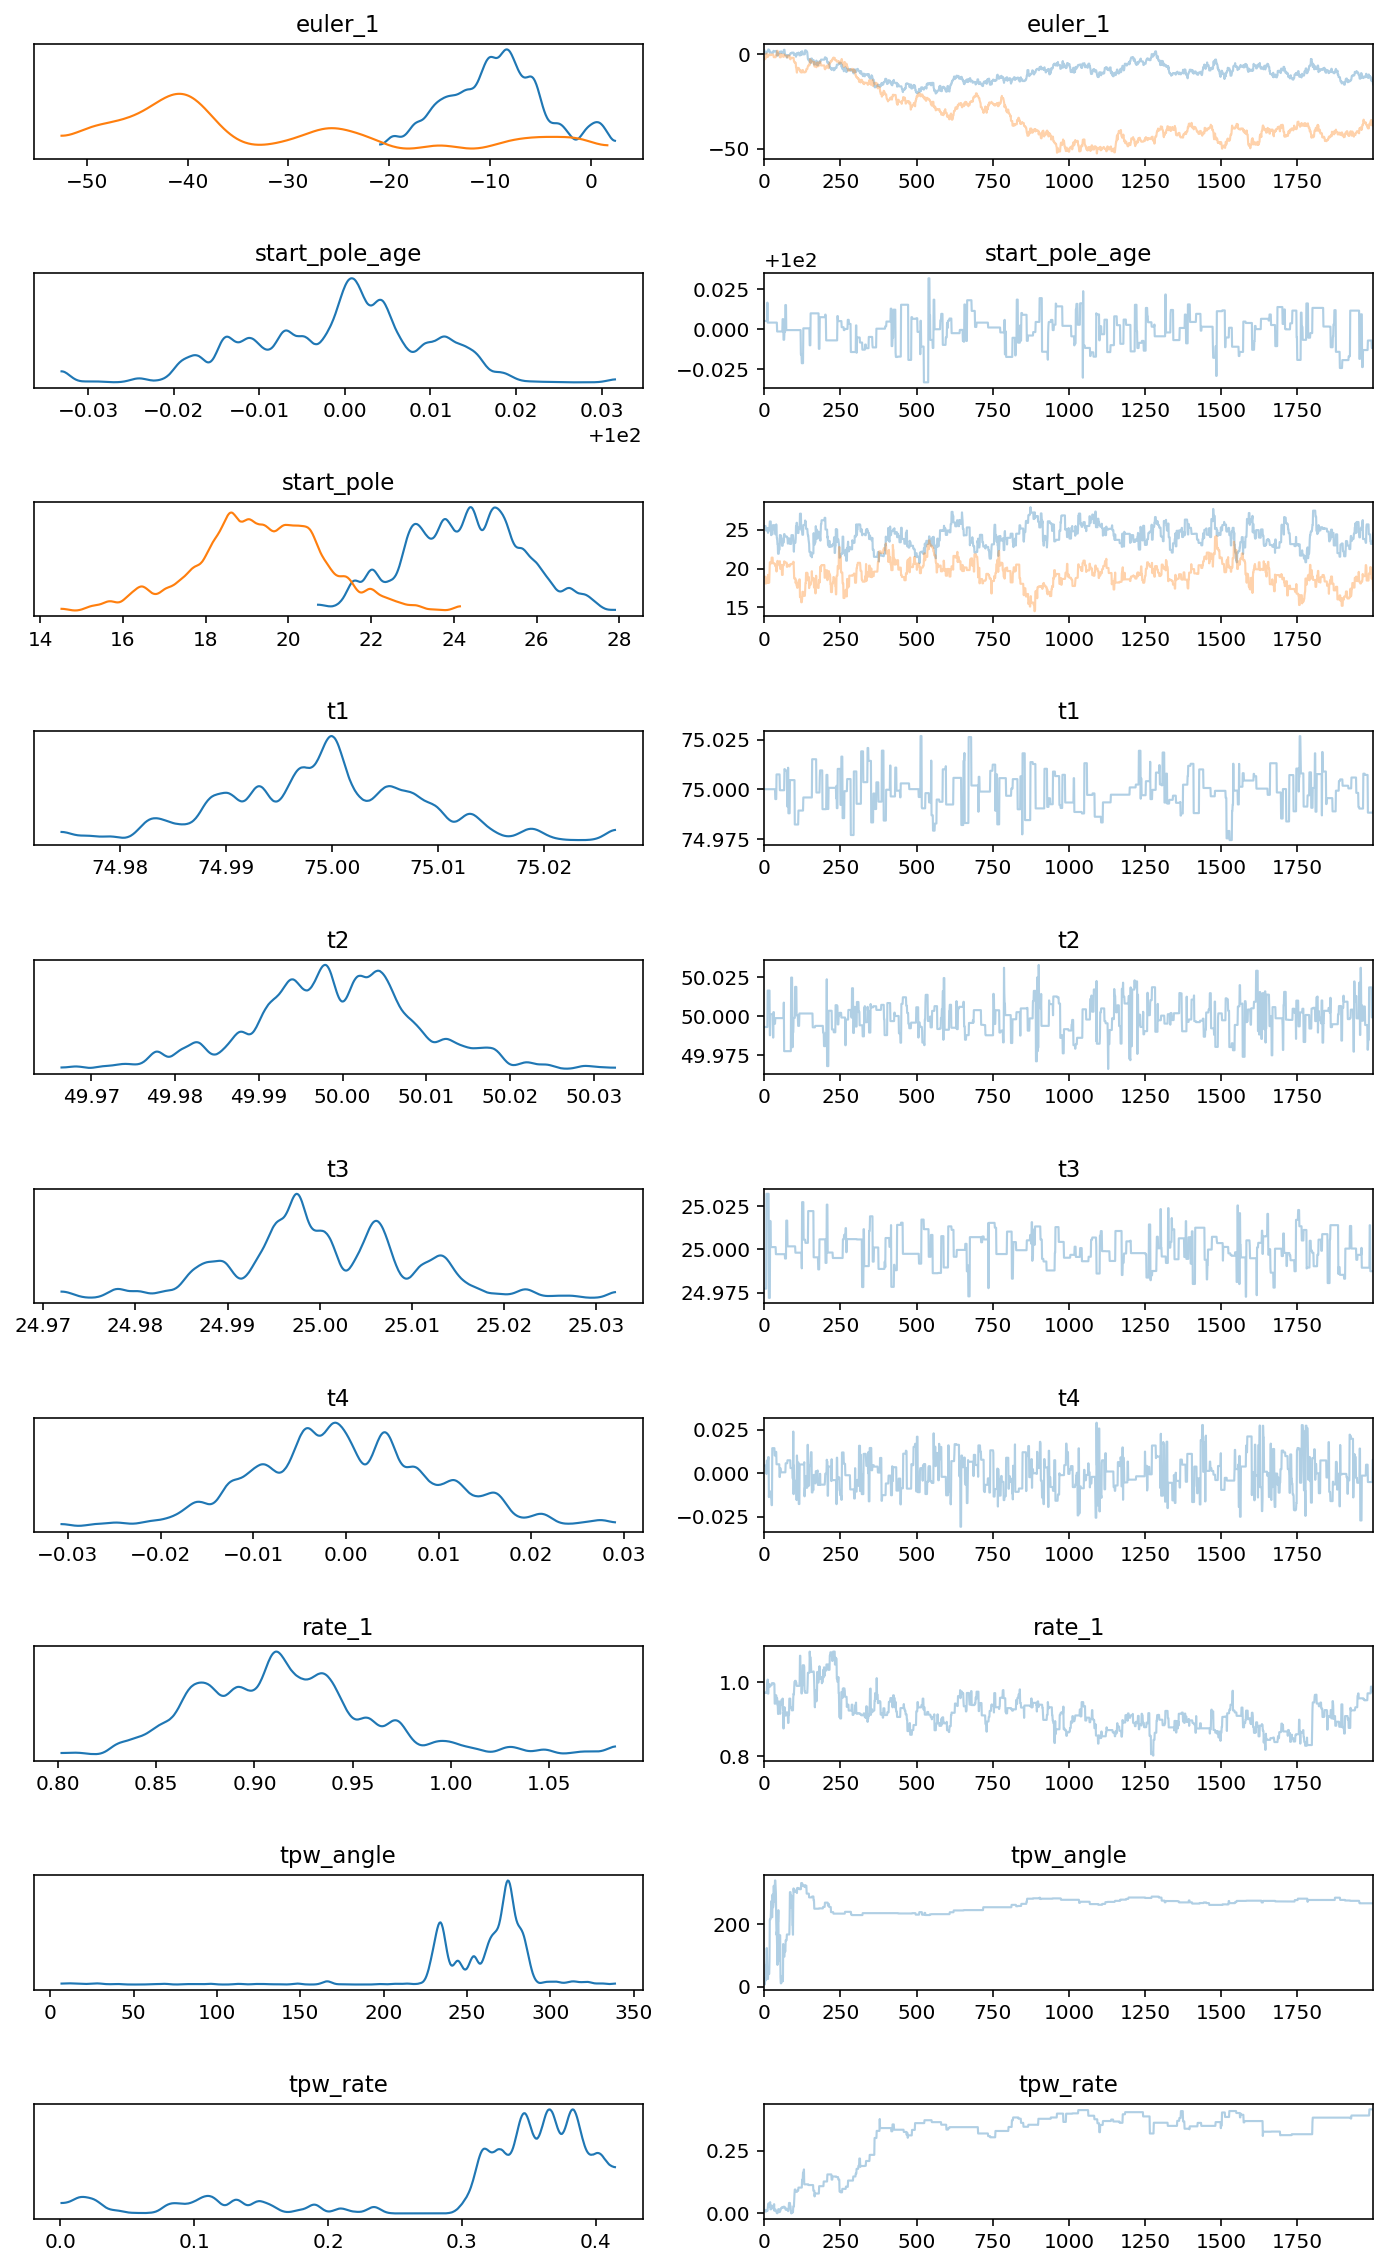

In [75]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_1e_tpw, compact=1)
plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/1_euler_tpw_inversion_traceplot.pdf', bbox_inches='tight')

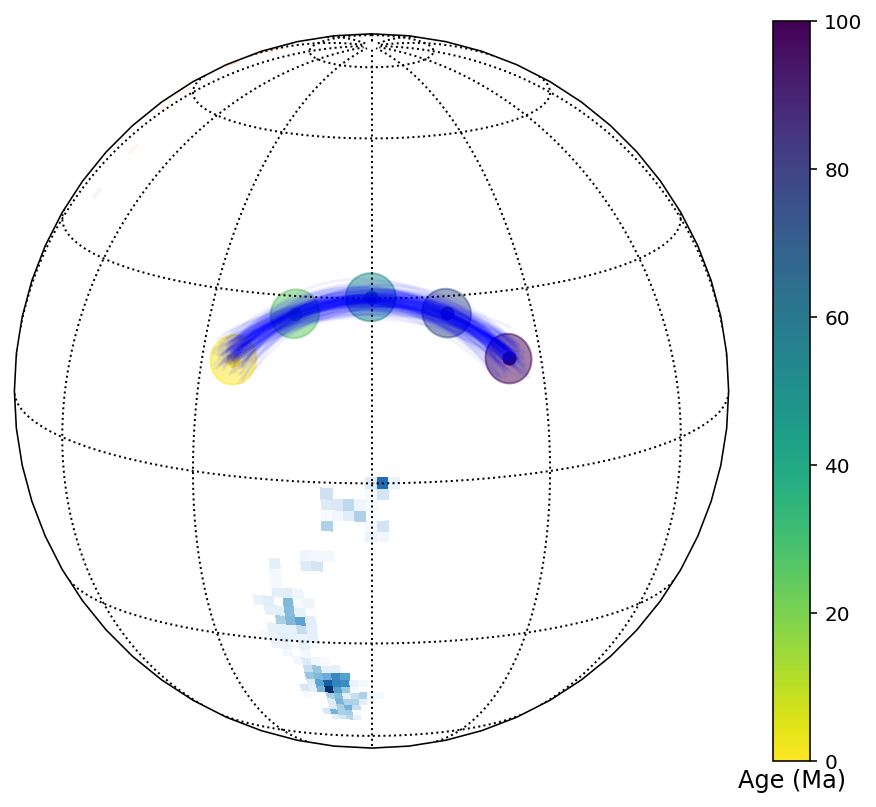

In [80]:
plot_trace_1e_tpw(trace_1e_tpw, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=15, num_paths_to_plot=200, savefig = 0, figname='code_output/1_Euler_tpw_inversion_.pdf')

## only tpw inversion

In [58]:
start_age = 100
end_age = 0
number_of_poles = 5
euler_pole = [0,0]
euler_rate = 1
pole_a95 = 4
start_pole = [24, 19]

one_euler_data = generate_APWP_poles(number_of_poles, start_pole, start_age, end_age, euler_pole, euler_rate, pole_a95)
one_euler_data

pole_lon   pole_lat  pole_age  pole_a95
0   24.000000  19.000000     100.0       4.0
1   13.724333  27.231977      75.0       4.0
2  359.854182  30.256654      50.0       4.0
3  346.026499  27.112309      25.0       4.0
4  335.843743  18.796033       0.0       4.0

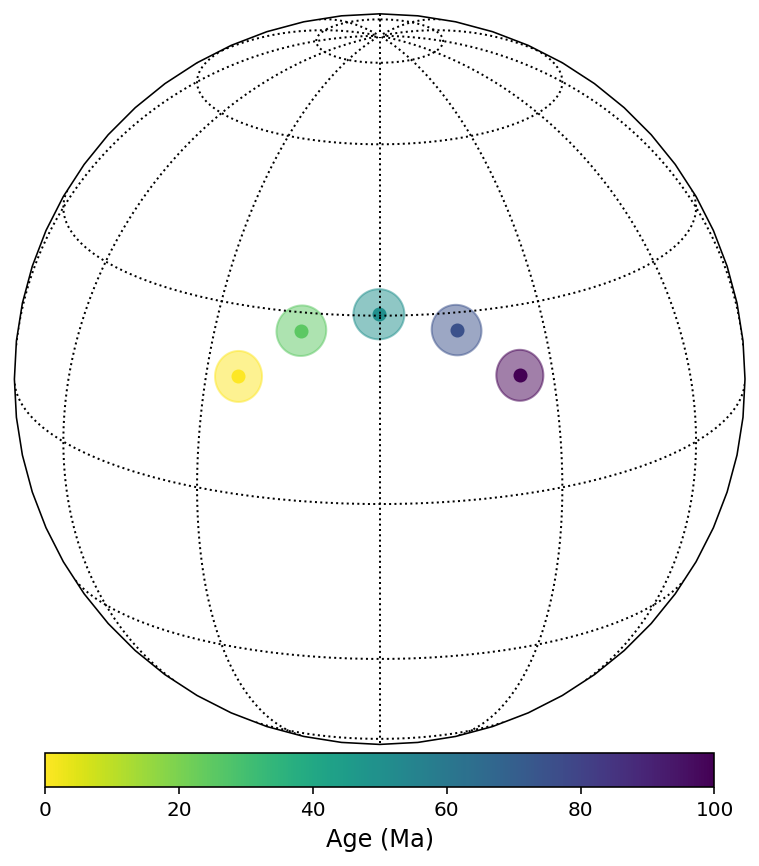

In [59]:
plot_paleomagnetic_poles(one_euler_data, central_latitude=20, add_land=0);

In [61]:
with pm.Model() as model:
    
    #set the the start age to be a tight normal distribution about the oldest pole age
    start_age = pm.Normal('start_pole_age', mu=one_euler_data['pole_age'].max(), sigma=0.01)
    print('starting pole age is: ', str(one_euler_data['pole_age'].max()))
    
    #set the start point of the path to be associated with the oldest paleomagnetic pole
    start_index = one_euler_data['pole_age'].argmax()
    start_lon_lat = [one_euler_data['pole_lon'].tolist()[start_index], one_euler_data['pole_lat'].tolist()[start_index]]
    start_k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[start_index])
    start = VMF('start_pole', lon_lat=start_lon_lat, 
                k = start_k, testval = np.array([1., 1.]), shape = 2)
    print('starting pole lon/lat:', start_lon_lat, 'starting pole k: ',start_k)
    
    tpw_angle = pm.Uniform('tpw_angle', 0., 360.) 
    tpw_rate = pm.Uniform('tpw_rate', 0., 4.) 
    
    #create the Fisher distributions associated with the observed pole positions 
    for j in range(one_euler_data.shape[0]-1):
        i = j + 1
        age = pm.Normal('t'+str(i), mu=one_euler_data['pole_age'][i], sigma=0.01)
        print('pole '+str(i)+' age: ',one_euler_data['pole_age'][i])
        
        lon_lat = pole_position_tpw(start, tpw_angle, tpw_rate, start_age, age)

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(one_euler_data['pole_a95'].tolist()[i]), 
                            observed=[one_euler_data['pole_lon'].tolist()[i], one_euler_data['pole_lat'].tolist()[i]])
        
#     uncomment to run the model
#     trace_tpw = pm.sample(2000, step = pm.Metropolis(), chains=1, init='auto')

starting pole age is:  100.0
starting pole lon/lat: [24.0, 19.0] starting pole k:  1225.0
pole 1 age:  75.0
pole 2 age:  50.0
pole 3 age:  25.0
pole 4 age:  0.0


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [t4]
>Metropolis: [t3]
>Metropolis: [t2]
>Metropolis: [t1]
>Metropolis: [tpw_rate]
>Metropolis: [tpw_angle]
>Metropolis: [start_pole]
>Metropolis: [start_pole_age]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 113 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [62]:
pm.save_trace(trace_tpw, 'code_output/tpw_trace', overwrite=1)

'code_output/tpw_trace'

In [63]:
trace_tpw_saved = pm.load_trace('code_output/tpw_trace',model)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


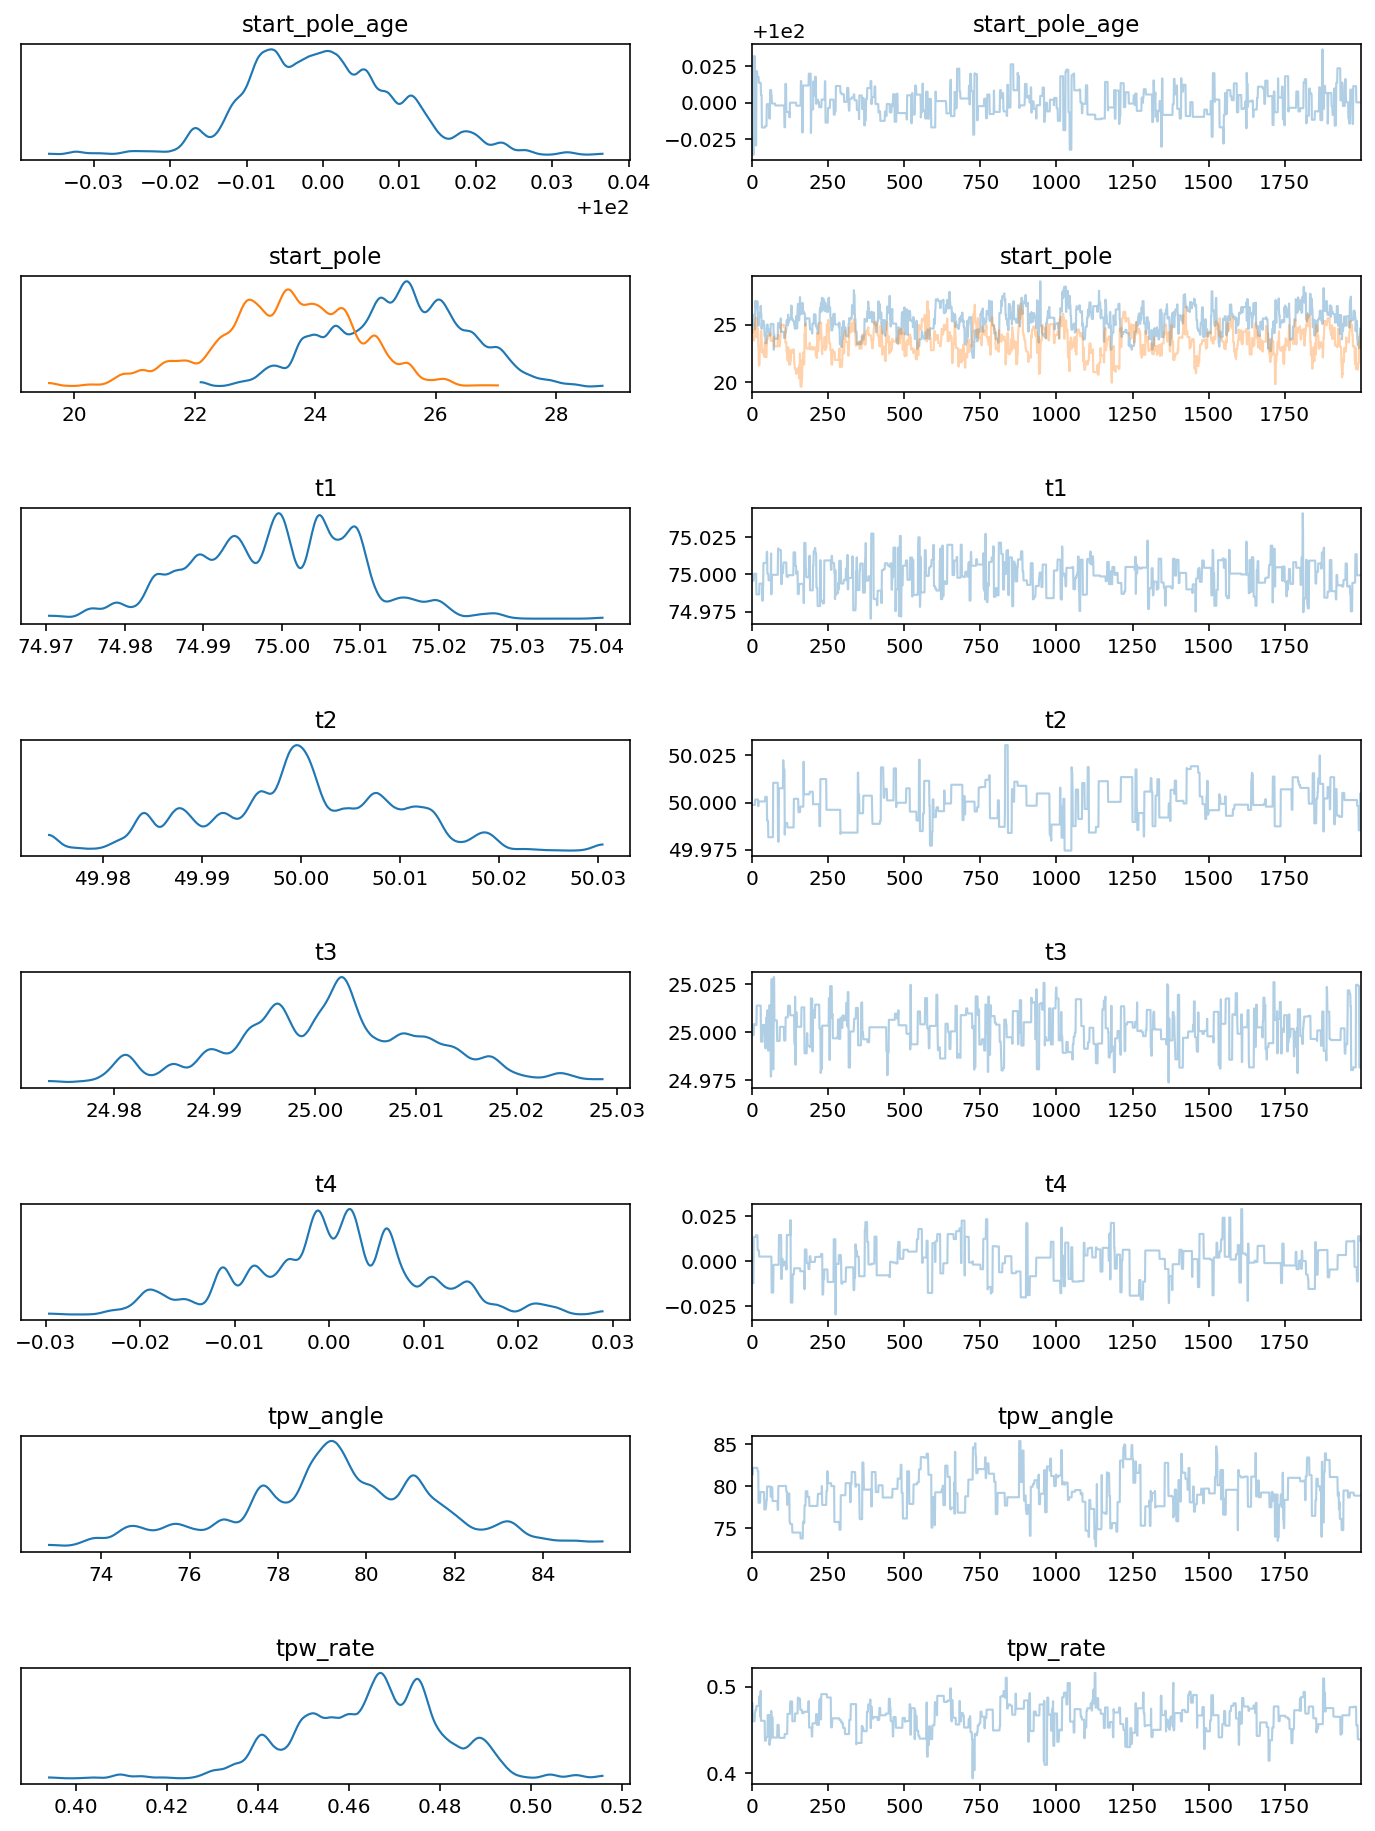

In [64]:
# plt.figure(figsize=(10, 20))
axes = pm.traceplot(trace_tpw_saved, compact=1)
plt.subplots_adjust(hspace = 1 )
# plt.savefig('code_output/1_euler_tpw_inversion_traceplot.pdf', bbox_inches='tight')

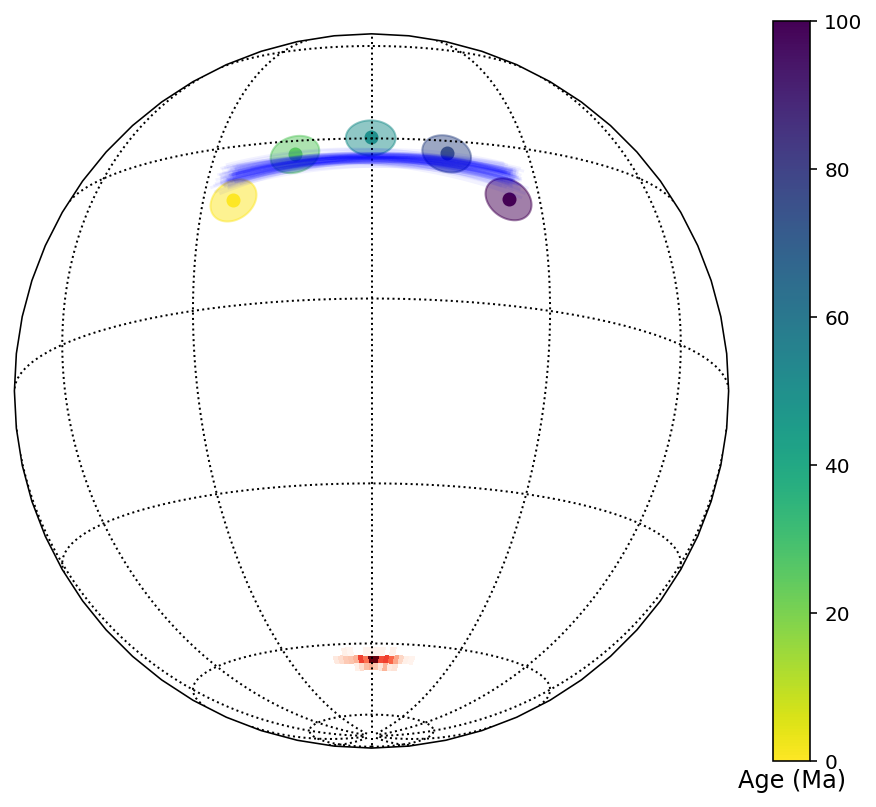

In [69]:
plot_trace_tpw(trace_tpw_saved, one_euler_data[['pole_lon', 'pole_lat']].to_numpy(), one_euler_data['pole_a95'], one_euler_data['pole_age'].tolist(), 
              central_lon=0, central_lat=-15, num_points_to_plot=100, num_paths_to_plot=100, savefig = 1, figname='code_output/tpw_inversion.pdf',)

### APWP class

In [71]:
def pole_position(start, start_age, this_age, euler_list, rate_list, changepoint_list, tpw_pole_angle=0., tpw_rate=0.):
#         if len(args) != max( (n_euler_poles * 3 - 1), 0):
#             raise Exception("Unexpected number of euler poles/changepoints: expected %i, got %i"%(n_euler_poles*3-1, len(args)))
        n_euler_poles = len(euler_list)
#         if len(changepoint_list)==0:
#             changepoint_list.append(0.0)
        changepoint_list = np.sort(changepoint_list)[::-1]
#         print(changepoint_list)
        # make a starting pole
        start_pole = PaleomagneticPole(start[0], start[1], age=this_age)

        # make a TPW pole
        test_1 = np.array([0.,0.,1.])
        test_2 = np.array([1.,0.,0.])

        # determine which side the tpw pole is on the globe
#         if np.dot(start_pole_cart, test_1) > np.dot(start_pole_cart, test_2):
        if T.gt(np.dot(start_pole._pole, test_1), np.dot(start_pole._pole, test_2)):
            tpw_pole = np.cross(start_pole._pole, test_2) # tpw pole in cartesian coordinates
        else:
            tpw_pole = np.cross(start_pole._pole, test_1) # tpw pole in cartesian coordinates

    #         print(start_pole_cart, tpw_pole, tpw_pole_angle)
    #         tpw = rotate(start_pole_cart, tpw_pole, tpw_pole_angle)      # amount of tpw in cartesian coordinates

        if n_euler_poles == 0:
            start_pole = start_pole.rotate(tpw_pole, tpw_rate * (start_age-this_age))
        else:
            for e, r, c in zip(euler_list, rate_list, changepoint_list):
                # add tpw contribution
#                 this_euler = spherical_to_cartesian(e[0], e[1])
#                 this_euler = spherical_to_cartesian(e[0], e[1]) + tpw # cartesian coordinates current euler pole plus tpw
                if this_age < c:
                    angle = r * (start_age - c)
                    start_pole = start_pole.rotate(e, angle)
                    start_pole = c
                else:
                    angle = r * (start_age - this_age)
                    start_pole = start_pole.rotate(e, angle)
                    break

        lon, lat = start_pole.longitude, start_pole.latitude
        return T.stacklists([lon, lat])

In [74]:
theano.config.floatX = 'float64'
def create_model(name = None, 
                 paleomagnetic_pole_list = None, 
                 A95_list = None,
                 age_list = None, 
                 age_uncertainty_list = None,
                 age_uncertainty_type_list = None,
                 n_euler_poles=0, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 2000):
    
    assert name != None, "must have a model name"
    assert paleomagnetic_pole_list != None, "must have a paleomagnetic pole list"
    assert A95_list != None, "must have a A95 list"
    assert age_list != None, "must have an age list"
    assert age_uncertainty_list != None, "must have an age uncertainty list"
    assert age_uncertainty_type_list != None, "must have an age uncertainty type list"
    assert n_euler_poles >= 0 , "must have a nonnegative euler pole number"
    
    assert euler_rate > 0.0, "rate_scale must be a positive number."
    assert tpw_pole_angle == None or tpw_rate_scale > 0.0, "true polar wander angle must be nonnegative"
    assert tpw_rate_scale == None or tpw_rate_scale > 0.0, "true polar wander rate must be nonnegative"
    assert kw <= 0.0, "nonnegative Watson concentration parameters are not supported"
    
    
    
    start_age = max(age_list)
    start_pole = paleomagnetic_pole_list[np.argmax(age_list)]
    start_A95 = A95_list[np.argmax(age_list)]
    
    if tpw_rate_scale is None:
        include_tpw = False
    else:
        include_tpw = True
        
    with pm.Model() as APWP_model:   
        start = VMF('start', 
                    lon_lat = start_pole, 
                    k = kappa_from_two_sigma(start_A95), 
                    testval = np.array([1., 0.]), shape = 2)
        
        euler_list = []
        rate_list = []
        changepoint_list = []
        
        # set up true polar wander variable if necessary
        if include_tpw:
            tpw_pole_angle = pm.Uniform('tpw_pole_angle', 0., 360., testval=0., observed=False)
            tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)

        # Make Euler pole direction random variables
        for i in range(n_euler_poles):
            euler = VMF('euler_' + str(i+1), lon_lat=site_lon_lat, k=k, testval=np.array([1.,0.]), shape = 2)
            euler_list.append(euler)
            
        # Make Euler pole rate random variables
        for i in range(n_euler_poles):
            rate = pm.Exponential('rate_' + str(i+1), euler_rate)
            rate_list.append(rate)
            
        # Make changepoint random variables
        for i in range(n_euler_poles - 1):
            changepoint = pm.Uniform('changepoint_' + str(i+1),lower = min(age_list), upper = max(age_list))
            changepoint_list.append(changepoint)
            
        for i, (this_pole, this_A95, this_age, this_age_uncertainty, this_uncertainty_type) in enumerate(
            zip(paleomagnetic_pole_list, A95_list, age_list, age_uncertainty_list, age_uncertainty_type_list)):
                

            if this_uncertainty_type == 'gaussian':
                pole_age = pm.Normal('a_' + str(i), mu=this_age, sd = this_age_uncertainty/2)
            elif this_uncertainty_type == 'uniform':
                pole_age = pm.Uniform('a_' + str(i), lower=this_age_uncertainty[0], upper=this_age_uncertainty[1])

            if include_tpw:
                
                lon_lat = pole_position(start, start_age, pole_age, euler_list, rate_list, changepoint_list, tpw_pole_angle, tpw_rate)
            else:
                lon_lat = pole_position(start, start_age, pole_age, euler_list, rate_list, changepoint_list)
            
#             print(lon_lat)
            observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(this_A95), observed=this_pole)
            
        trace = pm.sample(sample_size, step = pm.Metropolis(), compute_convergence_checks=False)
        
    return trace


In [ ]:
test_pmag_pole_list = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]
# test_pmag_pole_list = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
test_A95_list = [10., 10., 10., 10., 10.]
test_age_list =[40.,30.,20.,10., 0.]
test_age_uncertainty_list = [2., 2., 2., 2., 2.]
test_age_uncertainty_type = ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian']


test_trace = create_model(name = 'test', 
                 paleomagnetic_pole_list = test_pmag_pole_list, 
                 A95_list = test_A95_list,
                 age_list = test_age_list, 
                 age_uncertainty_list = test_age_uncertainty_list,
                 age_uncertainty_type_list = test_age_uncertainty_type,
                 n_euler_poles=2, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 1000)


TypeError: Variables do not support boolean operations.

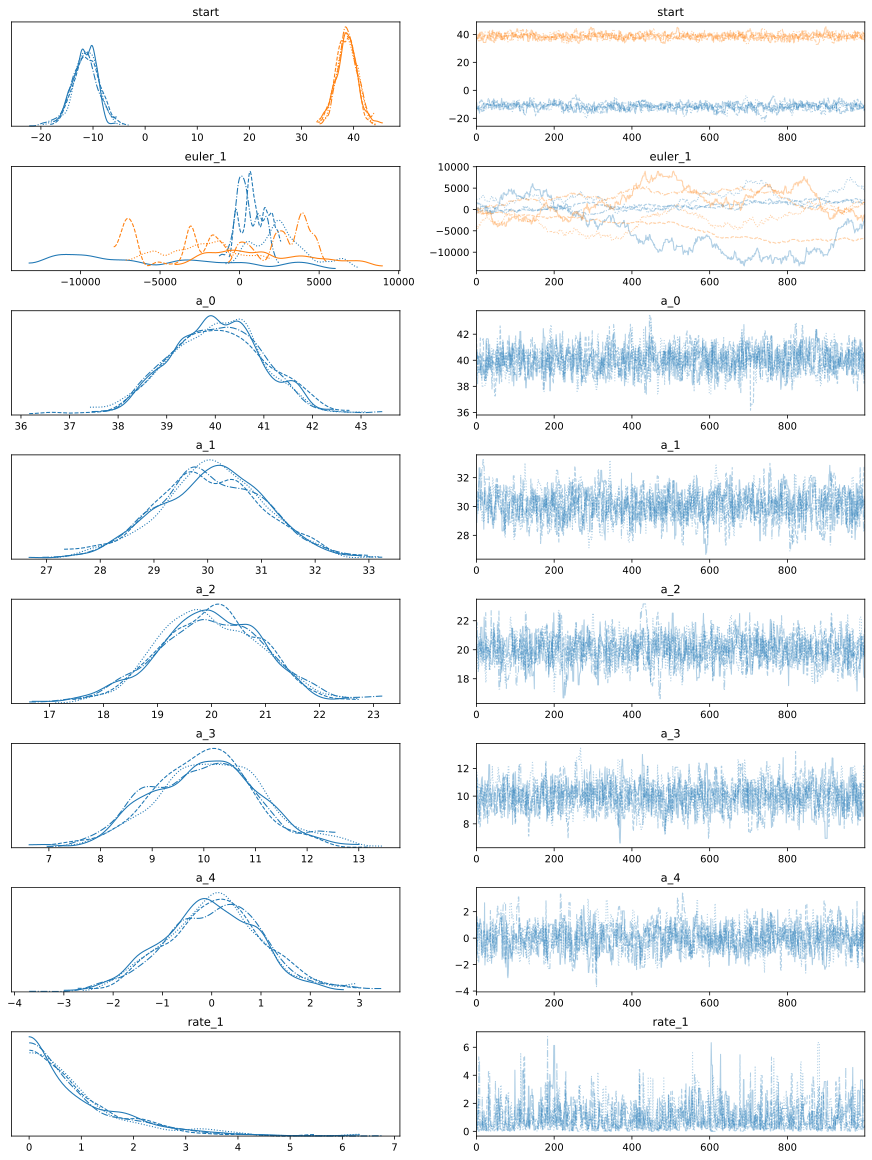

In [ ]:
pm.traceplot(test_trace);

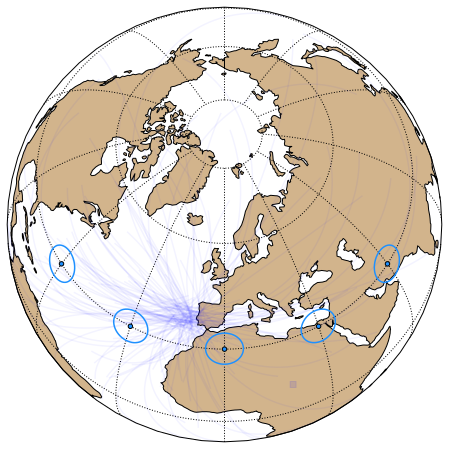

In [ ]:
plot_trace_1e(test_trace, test_pmag_pole_list, test_age_list, 0, 65, 200, 200, savefig = False)

In [ ]:
test_pmag_pole_list = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]
test_A95_list = [10., 10., 10., 10., 10.]
test_age_list =[0.,10.,20.,30.,40.]
test_age_uncertainty_list = [2., 2., 2., 2., 2.]
test_age_uncertainty_type = ['gaussian', 'gaussian', 'gaussian', 'gaussian', 'gaussian']


test_trace_2e = create_model(name = 'test', 
                 paleomagnetic_pole_list = test_pmag_pole_list, 
                 A95_list = test_A95_list,
                 age_list = test_age_list, 
                 age_uncertainty_list = test_age_uncertainty_list,
                 age_uncertainty_type_list = test_age_uncertainty_type,
                 n_euler_poles=2, 
                 include_tpw = False, 
                 site_lon_lat=[1., 0.], 
                 k=1., 
                 kw = -1., 
                 euler_rate=1., 
                 tpw_pole_angle = None,
                 tpw_rate_scale = None, 
                 sample_size = 2000)

In [ ]:
pm.traceplot(test_trace_2e);

In [ ]:
plot_trace(test_trace_2e, 0, 65, 200, 200, savefig = False)

In [31]:
def cartesian_to_spherical(vecs):
    v = np.reshape(vecs, (3, -1))
    norm = np.sqrt(v[0, :] * v[0, :] + v[1, :] * v[1, :] + v[2, :] * v[2, :])
    latitude = 90. - np.arccos(v[2, :] / norm) * r2d
    longitude = np.arctan(v[1, :]/v[0, :]) * r2d
    v1 = v[1, :]
    v0 = v[0, :]
    for i in range(len(longitude)):
        if T.lt(v1[i], 0) and T.lt(v0[i], 0):
            longitude[i] = longitude[i] + 180
        elif T.gt(v1[i], 0) and T.lt(v0[i], 0):
            longitude[i] = longitude[i] + 180

    return longitude, latitude, norm

In [ ]:
class APWP(object):

    def __init__(self, name, paleomagnetic_pole_list, n_euler_poles, sample_size = 2000):
        for p in paleomagnetic_pole_list:
            assert (isinstance(p, PaleomagneticPole))

        self._name = name
        self._poles = paleomagnetic_pole_list
        self.n_euler_rotations = n_euler_poles

        self._age_list = [p._age for p in self._poles]
        self._start_age = max(self._age_list)
        self._start_pole = self._poles[np.argmax(self._age_list)]
        self._sample_size = sample_size 
    
    def create_model(self, site_lon_lat=[1., 0.], k=1., kw = -1., euler_rate=1., tpw_rate_scale = None):
        assert euler_rate > 0.0, "rate_scale must be a positive number."
        assert tpw_rate_scale == None or tpw_rate_scale > 0.0
        assert kw <= 0.0, "Nonnegative Watson concentration parameters are not supported."
        if tpw_rate_scale is None:
            self.include_tpw = False
        else:
            self.include_tpw = True
            
        with pm.Model() as APWP_model:   
            start = VMF('start', 
                        lon_lat=[self._start_pole.longitude, self._start_pole.latitude], 
                        k=kappa_from_two_sigma(self._start_pole._A95), 
                        testval = np.array([1., 0.]), shape = 2)
            
#             if self.n_euler_rotations == 0 and tpw_rate_scale!= None:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', 0., 360., value=0., observed=False)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                
#             elif self.n_euler_rotations == 1:
#                 euler_1 = VMF('euler_1', lon_lat = [1., 0.], k = k, testval = np.array([1., 0.]), shape = 2)
#                 rate_1 = pm.Exponential('rate_1', euler_rate) 

#                 for i in range(len(self._poles)):
#                     p = self._poles[i]

#                     if p._age_type == 'gaussian':
#                         pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                     elif p._age_type == 'uniform':
#                         pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                     lon_lat = pole_position_1e(start, euler_1, rate_1, pole_age )
#                     observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
#             elif self.n_euler_rotations == 2:
                
            euler_1 = VMF('euler_1', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_1 = pm.Exponential('rate_1', euler_rate) 
            euler_2 = VMF('euler_2', lon_lat = site_lon_lat, k = k, testval = np.array([1., 0.]), shape = 2)
            rate_2 = pm.Exponential('rate_2', euler_rate) 
            switchpoint = pm.Uniform('switchpoint', min(self._age_list), max(self._age_list))
                
            for i in range(len(self._poles)):
                p = self._poles[i]

                if p._age_type == 'gaussian':
                    pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
                elif p._age_type == 'uniform':
                    pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

                lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
                observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
                    
            trace = pm.sample(self._sample_size, step = pm.Metropolis())
#             for i in range(len(self._poles)):
#                 p = self._poles[i]

# #                 time = self._start_age
#                 if p._age_type == 'gaussian':
#                     pole_age = pm.Normal('t'+str(i), mu=self._age_list[i], tau=1/(p._sigma_age**-2))
#                 elif p._age_type == 'uniform':
#                     pole_age = pm.Uniform('t'+str(i), lower=p._sigma_age[0], upper=p._sigma_age[1])

#                 if self.n_euler_rotations == 2:
#                     lon_lat = pole_position(start, eulers[0], rates[0], eulers[1], rates[1], changes[0], pole_age)
#                 lon_lat = pole_position(start, euler_1, rate_1, euler_2, rate_2, switchpoint, pole_age )
#                 observed_pole = VMF('p'+str(i), lon_lat, k=kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#                 observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(p._A95), observed=[p.longitude, p.latitude])
#             if self.include_tpw:
#                 tpw_pole_angle = pm.Uniform('tpw_pole_angle', lower = 0., upper = 360.)
#                 tpw_rate = pm.Exponential('tpw_rate', tpw_rate_scale)
                   
        return trace

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.,10.,20.,30.,40.]
sigma_ages = [2., 2., 2., 2., 2.]

lonlats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
# lon_lats = [ [300., -20.], [340.,0.], [0.,30.], [20., 0.], [60.,-20.]]

poles = []
for a, s, ll in zip(ages, sigma_ages, lonlats):
    pole = PaleomagneticPole( ll[0], ll[1], A95=5., age=a, sigma_age=s)
    poles.append(pole)
    
path = APWP('apw', poles, 2)

print(path._name)
print(path._poles)
print(path.n_euler_rotations)
print(path._age_list)
print(path._start_age)
print(path._start_pole)

trace = path.create_model()

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
plot_trace_1e(trace, 150, 65, 200, 200, savefig = False, figname = '1_euler_inversion_Monster_Shift.pdf')

In [ ]:
theano.config.floatX = 'float64'
# Generate a synthetic data set
ages =[0.0, 12.9, 15.5, 27.0]
sigma_ages = [4.0, 1.1, 1.2, 8.0]
# sigma_ages = [2., 2., 2., 2., 2.]
lon_lats = [[203.1, 58.1], [184.1, 73.5], [198.9, 77.9], [90.3, 78.7]]

angular_errors = [3.8, 3.7, 4.1, 7.4]

with pm.Model() as model:

    euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
    rate_1 = pm.Exponential('rate_1', 1.) 
    
    start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(5.), testval = np.array([1., 0.]), shape = 2)


    for i in range(len(ages)):
        time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
#         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
        lon_lat = pole_position_1e(start, euler_1, rate_1, time )

        observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
    trace = pm.sample(3000, step = pm.Metropolis())
    
    

# theano.config.floatX = 'float64'
# # Generate a synthetic data set

# a95 = [3.8, 3.7, 4.1, 7.4]

# ages =[0.0, 12.9, 15.5, 27.0]
# sigma_ages = [4.0, 1.1, 1.2, 8.0]

# lon_lats = [[300., 30.], [330., 30.], [0., 30.], [30., 30.], [60., 30.]]
# with pm.Model() as model:

#     euler_1 = VMF('euler_1', lon_lat = [1.,0.,], k = 1., testval = np.array([1., 0.]), shape = 2)
#     rate_1 = pm.Exponential('rate_1', 1.) 
    
#     start = VMF('start', lon_lat=lon_lats[0], k = kappa_from_two_sigma(10.), testval = np.array([1., 0.]), shape = 2)


#     for i in range(len(ages)):
#         time = pm.Normal('t'+str(i), mu=ages[i], tau=sigma_ages[i])
# #         lon_lat = pm.DensityDist('ll'+str(i), lambda placehoder = 0., st=start, e1=euler_1, r1=rate_1, e2=euler_2, r2=rate_2, sw=switchpoint, t=time : pole_position(st, e1, r1, e2, r2, sw, t))
#         lon_lat = pole_position_1e(start, euler_1, rate_1, time )

#         observed_pole = VMF('p'+str(i), lon_lat, k = kappa_from_two_sigma(10.), observed=lon_lats[i])
#     trace = pm.sample(2500, step = pm.Metropolis())

In [ ]:
trace_dataframe = pm.trace_to_dataframe(trace)
trace_dataframe

In [ ]:
pm.traceplot(trace, ['start', 'euler_1', 'rate_1', 't0', 't1', 't2', 't3'])
plt.show()

In [ ]:
plot_trace_1e(trace, 150, 65, 200, 200, savefig = False, figname = '1_euler_inversion_example.pdf')

In [ ]:
theano.config.floatX = 'float64'

poles = []
for a, s, lon, lat, a95 in zip(ages, sigma_ages, lons, lats, A95_list):
    pole = PaleomagneticPole(lon, lat, A95=a95, age=a, sigma_age=s)
    poles.append(pole)
    
path = APWP('apw', poles, 2)

print(path._name)
print(path._poles)
print(path.n_euler_rotations)
print(path._age_list)
print(path._start_age)
print(path._start_pole)

trace = path.create_model()

In [ ]:
pm.traceplot(trace, ['euler_1', 'euler_2', 'rate_1', 'rate_2', 'start', 'switchpoint', 't0', 't1', 't2', 't3'])
plt.show()

poles, pole_names, pole_colors = create_model(data, 1, True)